In [1]:
# import necessary packages
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras

2024-04-09 18:54:14.721990: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Preparing Data

In [2]:
data_dir = '/Users/mario/Desktop/Code/ingredients'

In [3]:
import pathlib
import cv2
import imghdr

# image_exts = ['jpeg','jpg', 'bmp', 'png']

# for image_class in os.listdir(data_dir): 
#     for image in os.listdir(os.path.join(data_dir, image_class)):
#         image_path = os.path.join(data_dir, image_class, image)
#         try: 
#             img = cv2.imread(image_path)
#             tip = imghdr.what(image_path)
#             if tip not in image_exts: 
#                 print('Image not in ext list {}'.format(image_path))
#                 os.remove(image_path)
#         except Exception as e: 
#             print('Issue with image {}'.format(image_path))
#             os.remove(image_path)

from PIL import Image

supported_formats = ['JPEG', 'PNG']

# Filter out unsupported files
file_paths = []
for filename in os.listdir(data_dir):
    file_path = os.path.join(data_dir, filename)
    if not os.path.isfile(file_path):
        continue  # Skip directories
    try:
        with Image.open(file_path) as img:
            if img.format in supported_formats:
                file_paths.append(file_path)
            else:
                print(f"Ignoring unsupported file: {filename}")
    except Exception as e:
        print(f"Error processing file {filename}: {e}")

In [67]:
data_dir = '/Users/mario/Desktop/Code/ingredients_2'

In [68]:
data = pathlib.Path(data_dir)

In [69]:
# create training ds
img_height,img_width=224,224
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5454 files belonging to 30 classes.
Using 4364 files for training.


In [70]:
# create validation ds
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5454 files belonging to 30 classes.
Using 1090 files for validation.


In [71]:
class_names = train_ds.class_names

print(class_names)

['apple', 'avocado', 'banana', 'beans', 'beef', 'bellpepper', 'bread', 'butter', 'carrot', 'cheese', 'chicken', 'eggs', 'fish', 'flour', 'garlic', 'honey', 'lentils', 'lettuce', 'lime', 'milk', 'oats', 'onion', 'pasta', 'pork', 'potato', 'rice', 'spinach', 'sugar', 'tofu', 'tomato']


2024-04-10 01:42:12.982079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:42:14.494568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:42:14.516490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:42:14.557446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:42:14.700669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:42:14.717872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:42:14.765674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:42:14.834671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:42:14.877981: W tensorflow/core/lib/png/png_io.cc:88] PNG 

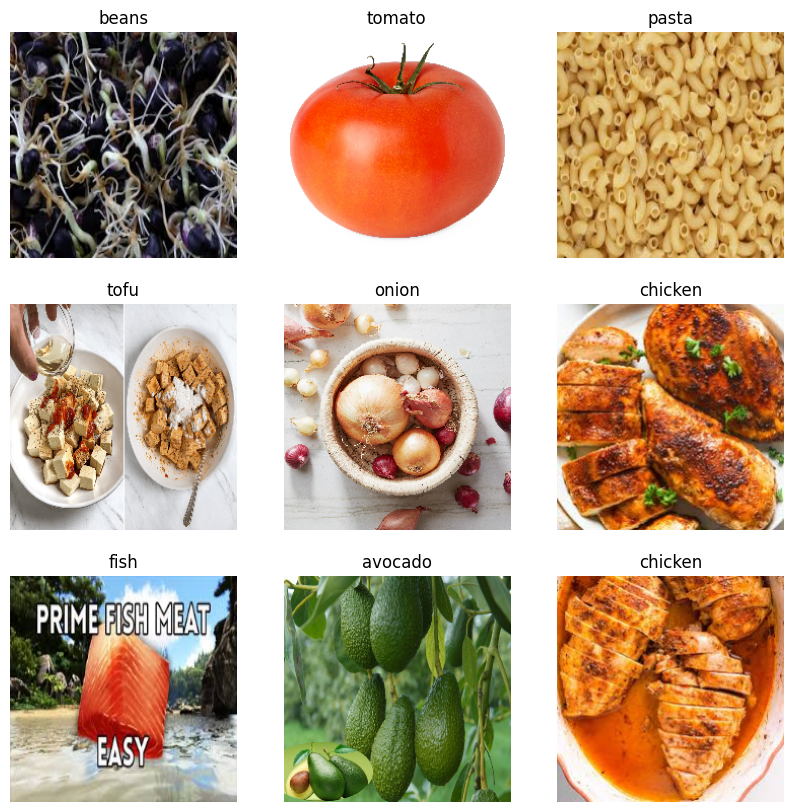

In [73]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Training Model

In [74]:
def preprocess_label(label):
    num_classes = 30  # Assuming 30 classes
    return tf.one_hot(label, num_classes)

train_ds = train_ds.map(lambda x, y: (x, preprocess_label(y)))
val_ds = val_ds.map(lambda x, y: (x, preprocess_label(y)))

In [77]:
# create model instance
resnet_model = tf.keras.Sequential()

# import pre-trained model
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg', classes=30,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

# add layer for our purpose
resnet_model.add(pretrained_model)
resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(512, activation='relu'))
resnet_model.add(tf.keras.layers.Dense(30, activation='sigmoid'))

In [78]:
resnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dense_7 (Dense)             (None, 30)                15390     
                                                                 
Total params: 24652190 (94.04 MB)
Trainable params: 1064478 (4.06 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [79]:
resnet_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [80]:
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10


2024-04-10 01:42:48.661081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:42:50.412878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:42:50.424929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:42:50.473498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:42:50.590326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:42:50.598483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:42:50.640239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:42:50.705601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:42:50.747371: W tensorflow/core/lib/png/png_io.cc:88] PNG 

  1/137 [..............................] - ETA: 37:03 - loss: 0.8522 - accuracy: 0.0938

2024-04-10 01:43:01.914441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:43:02.316314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:43:02.331705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:43:03.017822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/137 [..............................] - ETA: 11:50 - loss: 0.5445 - accuracy: 0.0469

2024-04-10 01:43:08.912392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:43:09.499108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/137 [..............................] - ETA: 11:28 - loss: 0.4223 - accuracy: 0.0417

2024-04-10 01:43:10.448521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:43:10.699974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:43:10.743602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:43:10.745442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:43:10.873092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/137 [..............................] - ETA: 11:16 - loss: 0.3632 - accuracy: 0.0469

2024-04-10 01:43:15.938309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/137 [>.............................] - ETA: 10:47 - loss: 0.3343 - accuracy: 0.0500

2024-04-10 01:43:19.938109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/137 [>.............................] - ETA: 10:47 - loss: 0.3157 - accuracy: 0.0469

2024-04-10 01:43:25.364227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/137 [>.............................] - ETA: 11:35 - loss: 0.3023 - accuracy: 0.0491

2024-04-10 01:43:32.316587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/137 [>.............................] - ETA: 11:40 - loss: 0.2934 - accuracy: 0.0508

2024-04-10 01:43:38.356678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:43:39.464169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/137 [>.............................] - ETA: 12:19 - loss: 0.2835 - accuracy: 0.0521

2024-04-10 01:43:46.404812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:43:47.752586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/137 [=>............................] - ETA: 12:29 - loss: 0.2754 - accuracy: 0.0625

2024-04-10 01:43:53.297207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/137 [=>............................] - ETA: 12:19 - loss: 0.2700 - accuracy: 0.0739

2024-04-10 01:43:59.010654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:43:59.020394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/137 [=>............................] - ETA: 12:24 - loss: 0.2597 - accuracy: 0.0817

2024-04-10 01:44:12.231883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:44:12.236993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:44:12.597791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:44:16.898986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:44:17.895483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:44:17.897187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/137 [==>...........................] - ETA: 12:40 - loss: 0.2515 - accuracy: 0.0938

2024-04-10 01:44:21.149440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/137 [==>...........................] - ETA: 13:13 - loss: 0.2373 - accuracy: 0.1191

2024-04-10 01:44:38.497553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:44:38.504716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:44:38.709591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:44:38.864542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:44:39.313719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/137 [==>...........................] - ETA: 12:55 - loss: 0.2334 - accuracy: 0.1232

2024-04-10 01:44:43.709199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:44:43.717354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/137 [===>..........................] - ETA: 12:20 - loss: 0.2221 - accuracy: 0.1349

2024-04-10 01:44:53.525178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/137 [===>..........................] - ETA: 11:50 - loss: 0.2086 - accuracy: 0.1562

2024-04-10 01:45:10.239837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:45:10.394886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/137 [====>.........................] - ETA: 11:45 - loss: 0.2050 - accuracy: 0.1630

2024-04-10 01:45:16.468977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:45:17.250675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/137 [====>.........................] - ETA: 11:38 - loss: 0.2009 - accuracy: 0.1693

2024-04-10 01:45:22.413811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:45:23.503485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/137 [====>.........................] - ETA: 11:30 - loss: 0.1970 - accuracy: 0.1800

2024-04-10 01:45:29.118362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/137 [====>.........................] - ETA: 11:25 - loss: 0.1938 - accuracy: 0.1911

2024-04-10 01:45:34.771963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/137 [=====>........................] - ETA: 11:06 - loss: 0.1877 - accuracy: 0.2042

2024-04-10 01:45:46.070132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/137 [=====>........................] - ETA: 10:59 - loss: 0.1849 - accuracy: 0.2144

2024-04-10 01:45:51.689206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:45:51.984662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/137 [=====>........................] - ETA: 10:44 - loss: 0.1795 - accuracy: 0.2288

2024-04-10 01:46:04.325708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:46:04.495804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/137 [======>.......................] - ETA: 10:39 - loss: 0.1776 - accuracy: 0.2314

2024-04-10 01:46:09.801244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/137 [======>.......................] - ETA: 10:31 - loss: 0.1754 - accuracy: 0.2367

2024-04-10 01:46:14.748183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/137 [======>.......................] - ETA: 10:23 - loss: 0.1727 - accuracy: 0.2491

2024-04-10 01:46:20.083302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:46:20.361486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/137 [======>.......................] - ETA: 10:18 - loss: 0.1707 - accuracy: 0.2545

2024-04-10 01:46:26.388346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:46:27.831974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/137 [======>.......................] - ETA: 10:12 - loss: 0.1688 - accuracy: 0.2578

2024-04-10 01:46:32.500813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/137 [=======>......................] - ETA: 10:02 - loss: 0.1668 - accuracy: 0.2644

2024-04-10 01:46:38.469974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/137 [=======>......................] - ETA: 9:54 - loss: 0.1648 - accuracy: 0.2714 

2024-04-10 01:46:42.781015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:46:43.014689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/137 [=======>......................] - ETA: 9:45 - loss: 0.1629 - accuracy: 0.2764

2024-04-10 01:46:47.363434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/137 [=======>......................] - ETA: 9:36 - loss: 0.1610 - accuracy: 0.2820

2024-04-10 01:46:51.959249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:46:52.329476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/137 [========>.....................] - ETA: 9:18 - loss: 0.1580 - accuracy: 0.2909

2024-04-10 01:47:01.400543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:47:01.518800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/137 [========>.....................] - ETA: 9:10 - loss: 0.1565 - accuracy: 0.2943

2024-04-10 01:47:06.322128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:47:06.481724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/137 [========>.....................] - ETA: 9:01 - loss: 0.1554 - accuracy: 0.2969

2024-04-10 01:47:11.955085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/137 [=========>....................] - ETA: 8:45 - loss: 0.1524 - accuracy: 0.3064

2024-04-10 01:47:20.185118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:47:20.457164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:47:20.483141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/137 [=========>....................] - ETA: 8:37 - loss: 0.1507 - accuracy: 0.3118

2024-04-10 01:47:24.775106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:47:24.914008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:47:25.001323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:47:27.043261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/137 [=========>....................] - ETA: 8:30 - loss: 0.1492 - accuracy: 0.3184

2024-04-10 01:47:29.678702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/137 [=========>....................] - ETA: 8:22 - loss: 0.1481 - accuracy: 0.3227

2024-04-10 01:47:34.903931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:47:34.909291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/137 [=========>....................] - ETA: 8:15 - loss: 0.1468 - accuracy: 0.3275

2024-04-10 01:47:40.630035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/137 [==========>...................] - ETA: 8:09 - loss: 0.1456 - accuracy: 0.3315

2024-04-10 01:47:44.914190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:47:44.946070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:47:45.126480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:47:45.128093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:47:45.632621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/137 [==========>...................] - ETA: 8:02 - loss: 0.1445 - accuracy: 0.3359

2024-04-10 01:47:49.668304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/137 [==========>...................] - ETA: 7:48 - loss: 0.1423 - accuracy: 0.3432

2024-04-10 01:47:59.431992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:47:59.484334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/137 [===========>..................] - ETA: 7:34 - loss: 0.1406 - accuracy: 0.3493

2024-04-10 01:48:08.795361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:48:09.737373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/137 [===========>..................] - ETA: 7:20 - loss: 0.1390 - accuracy: 0.3545

2024-04-10 01:48:18.904039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:48:19.602223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:48:19.619317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/137 [===========>..................] - ETA: 7:13 - loss: 0.1382 - accuracy: 0.3554

2024-04-10 01:48:22.689322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:48:23.466304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:48:23.751555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/137 [============>.................] - ETA: 7:07 - loss: 0.1374 - accuracy: 0.3589

2024-04-10 01:48:27.821174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:48:28.158634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:48:28.480097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/137 [============>.................] - ETA: 7:00 - loss: 0.1365 - accuracy: 0.3617

2024-04-10 01:48:33.715036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/137 [============>.................] - ETA: 6:53 - loss: 0.1357 - accuracy: 0.3644

2024-04-10 01:48:36.865478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:48:36.958296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:48:37.352694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/137 [=============>................] - ETA: 6:40 - loss: 0.1340 - accuracy: 0.3701

2024-04-10 01:48:46.004169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:48:46.219521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/137 [=============>................] - ETA: 6:33 - loss: 0.1334 - accuracy: 0.3716

2024-04-10 01:48:50.965425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/137 [=============>................] - ETA: 6:20 - loss: 0.1318 - accuracy: 0.3769

2024-04-10 01:48:59.428391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/137 [==============>...............] - ETA: 6:08 - loss: 0.1307 - accuracy: 0.3818

2024-04-10 01:49:08.318939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/137 [==============>...............] - ETA: 5:55 - loss: 0.1296 - accuracy: 0.3842

2024-04-10 01:49:18.887868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/137 [==============>...............] - ETA: 5:43 - loss: 0.1288 - accuracy: 0.3870

2024-04-10 01:49:26.357365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:49:26.536527: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/137 [===============>..............] - ETA: 5:36 - loss: 0.1280 - accuracy: 0.3902

2024-04-10 01:49:30.669360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:49:31.283886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/137 [===============>..............] - ETA: 5:24 - loss: 0.1266 - accuracy: 0.3964

2024-04-10 01:49:39.530556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:49:40.300170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/137 [===============>..............] - ETA: 5:18 - loss: 0.1258 - accuracy: 0.3994

2024-04-10 01:49:44.136651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:49:46.480093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/137 [================>.............] - ETA: 5:13 - loss: 0.1253 - accuracy: 0.4014

2024-04-10 01:49:49.118259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:49:49.722610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/137 [================>.............] - ETA: 5:07 - loss: 0.1246 - accuracy: 0.4039

2024-04-10 01:49:53.765398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:49:54.096064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/137 [================>.............] - ETA: 5:01 - loss: 0.1239 - accuracy: 0.4066

2024-04-10 01:49:57.918959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/137 [================>.............] - ETA: 4:55 - loss: 0.1235 - accuracy: 0.4078

2024-04-10 01:50:02.363135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:50:02.959891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/137 [================>.............] - ETA: 4:49 - loss: 0.1231 - accuracy: 0.4082

2024-04-10 01:50:06.729156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:50:07.326845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:50:07.336774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/137 [=================>............] - ETA: 4:43 - loss: 0.1224 - accuracy: 0.4108

2024-04-10 01:50:11.103406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:50:12.698824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:50:12.791752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:50:12.898341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/137 [=================>............] - ETA: 4:32 - loss: 0.1213 - accuracy: 0.4154

2024-04-10 01:50:21.081191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/137 [=================>............] - ETA: 4:26 - loss: 0.1207 - accuracy: 0.4182

2024-04-10 01:50:24.940388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/137 [==================>...........] - ETA: 4:21 - loss: 0.1202 - accuracy: 0.4210

2024-04-10 01:50:29.640173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/137 [==================>...........] - ETA: 4:15 - loss: 0.1198 - accuracy: 0.4215

2024-04-10 01:50:33.848572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:50:33.952992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/137 [==================>...........] - ETA: 4:09 - loss: 0.1194 - accuracy: 0.4224

2024-04-10 01:50:38.109878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/137 [==================>...........] - ETA: 4:04 - loss: 0.1188 - accuracy: 0.4250

2024-04-10 01:50:42.499736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:50:42.778814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:50:42.779923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/137 [==================>...........] - ETA: 3:58 - loss: 0.1183 - accuracy: 0.4262

2024-04-10 01:50:46.910506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:50:46.978464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/137 [===================>..........] - ETA: 3:52 - loss: 0.1178 - accuracy: 0.4287

2024-04-10 01:50:51.285627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/137 [===================>..........] - ETA: 3:47 - loss: 0.1171 - accuracy: 0.4321

2024-04-10 01:50:56.024732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/137 [===================>..........] - ETA: 3:41 - loss: 0.1168 - accuracy: 0.4332

2024-04-10 01:50:59.832859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:50:59.835899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/137 [====================>.........] - ETA: 3:25 - loss: 0.1156 - accuracy: 0.4365

2024-04-10 01:51:13.011720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:51:13.855819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:51:13.962546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/137 [====================>.........] - ETA: 3:14 - loss: 0.1145 - accuracy: 0.4407

2024-04-10 01:51:21.707060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:51:21.760559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:51:21.902070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/137 [====================>.........] - ETA: 3:09 - loss: 0.1140 - accuracy: 0.4437

2024-04-10 01:51:26.552919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/137 [=====================>........] - ETA: 2:58 - loss: 0.1131 - accuracy: 0.4482

2024-04-10 01:51:34.841768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/137 [=====================>........] - ETA: 2:52 - loss: 0.1128 - accuracy: 0.4499

2024-04-10 01:51:39.042003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:51:39.166020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/137 [=====================>........] - ETA: 2:47 - loss: 0.1123 - accuracy: 0.4528

2024-04-10 01:51:43.048239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/137 [=====================>........] - ETA: 2:42 - loss: 0.1120 - accuracy: 0.4545

2024-04-10 01:51:48.316321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/137 [======================>.......] - ETA: 2:37 - loss: 0.1115 - accuracy: 0.4564

2024-04-10 01:51:52.064078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:51:52.413829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:51:52.511708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/137 [======================>.......] - ETA: 2:31 - loss: 0.1111 - accuracy: 0.4582

2024-04-10 01:51:56.786053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/137 [======================>.......] - ETA: 2:26 - loss: 0.1107 - accuracy: 0.4598

2024-04-10 01:52:00.626433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:52:01.153278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:52:01.249754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/137 [======================>.......] - ETA: 2:21 - loss: 0.1104 - accuracy: 0.4610

2024-04-10 01:52:05.756544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/137 [=======================>......] - ETA: 2:16 - loss: 0.1100 - accuracy: 0.4622

2024-04-10 01:52:09.705530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/137 [=======================>......] - ETA: 2:10 - loss: 0.1097 - accuracy: 0.4642

2024-04-10 01:52:13.829791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/137 [=======================>......] - ETA: 2:05 - loss: 0.1095 - accuracy: 0.4657

2024-04-10 01:52:18.532725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/137 [=======================>......] - ETA: 2:00 - loss: 0.1091 - accuracy: 0.4679

2024-04-10 01:52:22.894476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/137 [=======================>......] - ETA: 1:55 - loss: 0.1088 - accuracy: 0.4693

2024-04-10 01:52:28.245855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/137 [========================>.....] - ETA: 1:50 - loss: 0.1084 - accuracy: 0.4712

2024-04-10 01:52:31.774722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:52:31.802787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:52:31.805416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/137 [========================>.....] - ETA: 1:45 - loss: 0.1081 - accuracy: 0.4723

2024-04-10 01:52:35.992994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/137 [========================>.....] - ETA: 1:34 - loss: 0.1072 - accuracy: 0.4756

2024-04-10 01:52:46.483264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/137 [=========================>....] - ETA: 1:29 - loss: 0.1069 - accuracy: 0.4772

2024-04-10 01:52:49.121956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/137 [=========================>....] - ETA: 1:19 - loss: 0.1063 - accuracy: 0.4796

2024-04-10 01:52:57.520015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:52:58.052529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:52:58.931126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:52:58.937843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/137 [==============================] - ETA: 0s - loss: 0.1020 - accuracy: 0.4973

2024-04-10 01:53:59.482647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:54:00.093789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:54:00.576832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:54:02.714119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:54:03.287290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:54:03.346860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:54:03.351282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:54:04.190610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:54:05.839333: W tensorflow/core/lib/png/png_io.cc:88] PNG 

137/137 [==============================] - 825s 6s/step - loss: 0.1020 - accuracy: 0.4973 - val_loss: 0.0711 - val_accuracy: 0.6138
Epoch 2/10


2024-04-10 01:56:29.540142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:56:31.419571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:56:31.433963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:56:31.477203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:56:31.608881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:56:31.616746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:56:31.671261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:56:31.749234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:56:31.802878: W tensorflow/core/lib/png/png_io.cc:88] PNG 

  1/137 [..............................] - ETA: 25:54 - loss: 0.0633 - accuracy: 0.7500

2024-04-10 01:56:41.029244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:56:44.234061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:56:44.666167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:56:44.755389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:56:45.436545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/137 [..............................] - ETA: 12:43 - loss: 0.0674 - accuracy: 0.6875

2024-04-10 01:56:51.293506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/137 [..............................] - ETA: 12:40 - loss: 0.0617 - accuracy: 0.6875

2024-04-10 01:56:52.254718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:56:52.346077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:56:52.607649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:56:52.670166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:56:52.671394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:56:52.801149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/137 [..............................] - ETA: 11:56 - loss: 0.0641 - accuracy: 0.6797

2024-04-10 01:56:57.316165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/137 [>.............................] - ETA: 11:20 - loss: 0.0663 - accuracy: 0.6562

2024-04-10 01:57:01.473611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/137 [>.............................] - ETA: 10:55 - loss: 0.0653 - accuracy: 0.6615

2024-04-10 01:57:05.989072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/137 [>.............................] - ETA: 10:33 - loss: 0.0624 - accuracy: 0.6696

2024-04-10 01:57:10.041079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/137 [>.............................] - ETA: 10:16 - loss: 0.0604 - accuracy: 0.6797

2024-04-10 01:57:14.321941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:57:15.307749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/137 [>.............................] - ETA: 10:07 - loss: 0.0584 - accuracy: 0.6979

2024-04-10 01:57:18.685756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:57:19.212040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/137 [=>............................] - ETA: 9:56 - loss: 0.0572 - accuracy: 0.7031 

2024-04-10 01:57:22.938447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/137 [=>............................] - ETA: 9:59 - loss: 0.0567 - accuracy: 0.7102

2024-04-10 01:57:28.338779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:57:28.356633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/137 [=>............................] - ETA: 9:41 - loss: 0.0577 - accuracy: 0.7043

2024-04-10 01:57:36.974734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:57:36.986285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:57:37.160480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:57:39.320768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:57:39.913391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:57:39.935232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/137 [==>...........................] - ETA: 9:38 - loss: 0.0585 - accuracy: 0.7009

2024-04-10 01:57:42.212311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/137 [==>...........................] - ETA: 9:23 - loss: 0.0581 - accuracy: 0.7051

2024-04-10 01:57:50.552273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:57:50.575511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:57:50.744676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:57:50.783044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:57:51.244794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/137 [==>...........................] - ETA: 9:17 - loss: 0.0586 - accuracy: 0.7022

2024-04-10 01:57:55.115571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:57:55.116946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/137 [===>..........................] - ETA: 9:04 - loss: 0.0587 - accuracy: 0.6957

2024-04-10 01:58:04.061328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/137 [===>..........................] - ETA: 8:50 - loss: 0.0591 - accuracy: 0.6861

2024-04-10 01:58:17.734631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:58:17.939433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/137 [====>.........................] - ETA: 8:45 - loss: 0.0589 - accuracy: 0.6875

2024-04-10 01:58:22.337506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:58:22.921881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/137 [====>.........................] - ETA: 8:42 - loss: 0.0584 - accuracy: 0.6927

2024-04-10 01:58:27.061747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:58:27.995877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/137 [====>.........................] - ETA: 8:37 - loss: 0.0584 - accuracy: 0.6925

2024-04-10 01:58:32.319254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/137 [====>.........................] - ETA: 8:34 - loss: 0.0578 - accuracy: 0.6959

2024-04-10 01:58:36.796644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/137 [=====>........................] - ETA: 8:23 - loss: 0.0569 - accuracy: 0.7020

2024-04-10 01:58:45.928960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/137 [=====>........................] - ETA: 8:17 - loss: 0.0569 - accuracy: 0.7015

2024-04-10 01:58:49.991231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:58:50.024950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/137 [=====>........................] - ETA: 8:05 - loss: 0.0574 - accuracy: 0.7006

2024-04-10 01:58:59.400774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:58:59.529499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/137 [======>.......................] - ETA: 8:00 - loss: 0.0572 - accuracy: 0.7021

2024-04-10 01:59:02.916507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/137 [======>.......................] - ETA: 7:54 - loss: 0.0568 - accuracy: 0.7036

2024-04-10 01:59:07.160959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/137 [======>.......................] - ETA: 7:49 - loss: 0.0570 - accuracy: 0.7022

2024-04-10 01:59:11.123906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:59:11.317841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/137 [======>.......................] - ETA: 7:44 - loss: 0.0575 - accuracy: 0.6982

2024-04-10 01:59:15.381565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:59:16.310515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/137 [======>.......................] - ETA: 7:38 - loss: 0.0570 - accuracy: 0.7005

2024-04-10 01:59:19.897195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/137 [=======>......................] - ETA: 7:33 - loss: 0.0564 - accuracy: 0.7052

2024-04-10 01:59:24.940368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/137 [=======>......................] - ETA: 7:29 - loss: 0.0564 - accuracy: 0.7064

2024-04-10 01:59:29.363174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:59:29.695434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/137 [=======>......................] - ETA: 7:25 - loss: 0.0562 - accuracy: 0.7075

2024-04-10 01:59:33.617979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/137 [=======>......................] - ETA: 7:20 - loss: 0.0565 - accuracy: 0.7070

2024-04-10 01:59:37.769886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:59:38.089595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/137 [========>.....................] - ETA: 7:09 - loss: 0.0565 - accuracy: 0.7091

2024-04-10 01:59:46.140471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:59:46.279519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/137 [========>.....................] - ETA: 7:04 - loss: 0.0565 - accuracy: 0.7093

2024-04-10 01:59:50.594966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 01:59:50.769912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/137 [========>.....................] - ETA: 6:59 - loss: 0.0565 - accuracy: 0.7102

2024-04-10 01:59:55.588419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/137 [=========>....................] - ETA: 6:49 - loss: 0.0559 - accuracy: 0.7140

2024-04-10 02:00:03.153532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:00:03.378644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:00:03.467127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/137 [=========>....................] - ETA: 6:44 - loss: 0.0557 - accuracy: 0.7168

2024-04-10 02:00:07.369606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:00:07.474473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:00:07.569160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:00:09.384934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/137 [=========>....................] - ETA: 6:40 - loss: 0.0559 - accuracy: 0.7148

2024-04-10 02:00:11.969643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/137 [=========>....................] - ETA: 6:35 - loss: 0.0560 - accuracy: 0.7136

2024-04-10 02:00:16.735006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:00:16.756575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/137 [=========>....................] - ETA: 6:30 - loss: 0.0560 - accuracy: 0.7125

2024-04-10 02:00:21.452604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/137 [==========>...................] - ETA: 6:26 - loss: 0.0559 - accuracy: 0.7132

2024-04-10 02:00:25.107780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:00:25.146460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:00:25.286344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:00:25.310062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:00:25.858280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/137 [==========>...................] - ETA: 6:21 - loss: 0.0556 - accuracy: 0.7163

2024-04-10 02:00:29.365129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/137 [==========>...................] - ETA: 6:11 - loss: 0.0553 - accuracy: 0.7170

2024-04-10 02:00:37.900915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:00:37.945679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/137 [===========>..................] - ETA: 6:01 - loss: 0.0547 - accuracy: 0.7215

2024-04-10 02:00:46.369124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:00:47.371430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/137 [===========>..................] - ETA: 5:51 - loss: 0.0548 - accuracy: 0.7198

2024-04-10 02:00:55.519546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:00:56.077785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:00:56.086747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/137 [===========>..................] - ETA: 5:47 - loss: 0.0548 - accuracy: 0.7214

2024-04-10 02:00:59.044761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:00:59.729120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:01:00.029973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/137 [============>.................] - ETA: 5:42 - loss: 0.0547 - accuracy: 0.7219

2024-04-10 02:01:03.777601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:01:04.020956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:01:04.288949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/137 [============>.................] - ETA: 5:38 - loss: 0.0546 - accuracy: 0.7223

2024-04-10 02:01:09.283351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/137 [============>.................] - ETA: 5:33 - loss: 0.0549 - accuracy: 0.7198

2024-04-10 02:01:12.255348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:01:12.344057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:01:12.642026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/137 [=============>................] - ETA: 5:24 - loss: 0.0547 - accuracy: 0.7212

2024-04-10 02:01:20.747775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:01:21.064473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/137 [=============>................] - ETA: 5:19 - loss: 0.0547 - accuracy: 0.7216

2024-04-10 02:01:25.477492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/137 [=============>................] - ETA: 5:10 - loss: 0.0547 - accuracy: 0.7220

2024-04-10 02:01:33.618949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/137 [==============>...............] - ETA: 5:01 - loss: 0.0549 - accuracy: 0.7201

2024-04-10 02:01:42.104502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/137 [==============>...............] - ETA: 4:52 - loss: 0.0549 - accuracy: 0.7223

2024-04-10 02:01:51.981712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/137 [==============>...............] - ETA: 4:43 - loss: 0.0547 - accuracy: 0.7243

2024-04-10 02:01:59.108338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:01:59.244728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/137 [===============>..............] - ETA: 4:38 - loss: 0.0544 - accuracy: 0.7259

2024-04-10 02:02:03.191847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:02:03.731257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/137 [===============>..............] - ETA: 4:29 - loss: 0.0542 - accuracy: 0.7278

2024-04-10 02:02:11.634365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:02:12.314686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/137 [===============>..............] - ETA: 4:24 - loss: 0.0540 - accuracy: 0.7289

2024-04-10 02:02:16.071451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:02:18.425232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/137 [================>.............] - ETA: 4:20 - loss: 0.0539 - accuracy: 0.7300

2024-04-10 02:02:20.891510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:02:21.510138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/137 [================>.............] - ETA: 4:16 - loss: 0.0538 - accuracy: 0.7306

2024-04-10 02:02:25.318560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:02:25.621550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/137 [================>.............] - ETA: 4:11 - loss: 0.0537 - accuracy: 0.7320

2024-04-10 02:02:29.343911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/137 [================>.............] - ETA: 4:07 - loss: 0.0536 - accuracy: 0.7326

2024-04-10 02:02:33.539676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:02:34.103136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/137 [================>.............] - ETA: 4:02 - loss: 0.0535 - accuracy: 0.7325

2024-04-10 02:02:37.835157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:02:38.509290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:02:38.527892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/137 [=================>............] - ETA: 3:57 - loss: 0.0534 - accuracy: 0.7331

2024-04-10 02:02:42.057233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:02:43.644743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:02:43.690841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:02:43.801739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/137 [=================>............] - ETA: 3:49 - loss: 0.0532 - accuracy: 0.7335

2024-04-10 02:02:51.633707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/137 [=================>............] - ETA: 3:44 - loss: 0.0532 - accuracy: 0.7336

2024-04-10 02:02:55.432023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/137 [==================>...........] - ETA: 3:40 - loss: 0.0529 - accuracy: 0.7349

2024-04-10 02:02:59.916071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/137 [==================>...........] - ETA: 3:35 - loss: 0.0531 - accuracy: 0.7340

2024-04-10 02:03:03.988414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:03:04.090200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/137 [==================>...........] - ETA: 3:31 - loss: 0.0530 - accuracy: 0.7360

2024-04-10 02:03:08.215623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/137 [==================>...........] - ETA: 3:26 - loss: 0.0529 - accuracy: 0.7372

2024-04-10 02:03:12.484823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:03:12.750583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:03:12.752131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/137 [==================>...........] - ETA: 3:22 - loss: 0.0527 - accuracy: 0.7383

2024-04-10 02:03:16.853725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:03:16.886962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/137 [===================>..........] - ETA: 3:17 - loss: 0.0526 - accuracy: 0.7385

2024-04-10 02:03:21.060761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/137 [===================>..........] - ETA: 3:13 - loss: 0.0526 - accuracy: 0.7379

2024-04-10 02:03:25.565801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/137 [===================>..........] - ETA: 3:08 - loss: 0.0526 - accuracy: 0.7377

2024-04-10 02:03:29.271913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:03:29.276155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/137 [====================>.........] - ETA: 2:55 - loss: 0.0524 - accuracy: 0.7381

2024-04-10 02:03:41.822586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:03:42.661986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:03:42.726400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/137 [====================>.........] - ETA: 2:46 - loss: 0.0522 - accuracy: 0.7393

2024-04-10 02:03:50.477460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:03:50.554534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:03:50.695516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/137 [====================>.........] - ETA: 2:42 - loss: 0.0522 - accuracy: 0.7394

2024-04-10 02:03:55.046251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/137 [=====================>........] - ETA: 2:33 - loss: 0.0519 - accuracy: 0.7408

2024-04-10 02:04:03.023092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/137 [=====================>........] - ETA: 2:28 - loss: 0.0518 - accuracy: 0.7412

2024-04-10 02:04:07.186507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:04:07.296054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/137 [=====================>........] - ETA: 2:24 - loss: 0.0518 - accuracy: 0.7419

2024-04-10 02:04:11.059356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/137 [=====================>........] - ETA: 2:19 - loss: 0.0518 - accuracy: 0.7420

2024-04-10 02:04:16.289247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/137 [======================>.......] - ETA: 2:15 - loss: 0.0517 - accuracy: 0.7429

2024-04-10 02:04:19.885366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:04:20.209775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:04:20.278649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/137 [======================>.......] - ETA: 2:11 - loss: 0.0517 - accuracy: 0.7421

2024-04-10 02:04:24.646618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/137 [======================>.......] - ETA: 2:06 - loss: 0.0517 - accuracy: 0.7416

2024-04-10 02:04:28.355429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:04:29.032138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:04:29.110009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/137 [======================>.......] - ETA: 2:02 - loss: 0.0516 - accuracy: 0.7431

2024-04-10 02:04:33.428275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/137 [=======================>......] - ETA: 1:58 - loss: 0.0517 - accuracy: 0.7418

2024-04-10 02:04:37.382778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/137 [=======================>......] - ETA: 1:53 - loss: 0.0516 - accuracy: 0.7430

2024-04-10 02:04:41.298664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/137 [=======================>......] - ETA: 1:49 - loss: 0.0516 - accuracy: 0.7427

2024-04-10 02:04:45.943977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/137 [=======================>......] - ETA: 1:44 - loss: 0.0515 - accuracy: 0.7434

2024-04-10 02:04:50.179055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/137 [=======================>......] - ETA: 1:40 - loss: 0.0514 - accuracy: 0.7448

2024-04-10 02:04:55.174100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/137 [========================>.....] - ETA: 1:36 - loss: 0.0513 - accuracy: 0.7457

2024-04-10 02:04:58.672272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:04:58.728543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:04:58.732755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/137 [========================>.....] - ETA: 1:31 - loss: 0.0511 - accuracy: 0.7465

2024-04-10 02:05:02.781666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/137 [========================>.....] - ETA: 1:22 - loss: 0.0510 - accuracy: 0.7471

2024-04-10 02:05:13.180249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/137 [=========================>....] - ETA: 1:18 - loss: 0.0509 - accuracy: 0.7474

2024-04-10 02:05:15.672076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/137 [=========================>....] - ETA: 1:09 - loss: 0.0508 - accuracy: 0.7490

2024-04-10 02:05:23.934574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:05:24.521821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:05:25.267374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:05:25.270667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/137 [==============================] - ETA: 0s - loss: 0.0500 - accuracy: 0.7557

2024-04-10 02:06:23.166245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:06:23.628007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:06:24.162742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:06:26.342519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:06:26.907367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:06:26.968895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:06:26.976929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:06:27.808965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:06:29.436053: W tensorflow/core/lib/png/png_io.cc:88] PNG 

137/137 [==============================] - 733s 5s/step - loss: 0.0500 - accuracy: 0.7557 - val_loss: 0.0595 - val_accuracy: 0.6936
Epoch 3/10


2024-04-10 02:08:42.724127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:08:44.659272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:08:44.672365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:08:44.720292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:08:44.872910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:08:44.962715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:08:45.011229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:08:45.107535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:08:45.177877: W tensorflow/core/lib/png/png_io.cc:88] PNG 

  1/137 [..............................] - ETA: 24:20 - loss: 0.0328 - accuracy: 0.8750

2024-04-10 02:08:53.248412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:08:55.994520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:08:56.397857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:08:56.481406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:08:57.123132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/137 [..............................] - ETA: 11:28 - loss: 0.0314 - accuracy: 0.8594

2024-04-10 02:09:02.356021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:09:03.012205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/137 [..............................] - ETA: 11:20 - loss: 0.0324 - accuracy: 0.8438

2024-04-10 02:09:03.303797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:09:03.662972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:09:03.722839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:09:03.736975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:09:03.824768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/137 [..............................] - ETA: 10:44 - loss: 0.0331 - accuracy: 0.8359

2024-04-10 02:09:08.174072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/137 [>.............................] - ETA: 10:20 - loss: 0.0379 - accuracy: 0.8125

2024-04-10 02:09:12.095203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/137 [>.............................] - ETA: 10:02 - loss: 0.0398 - accuracy: 0.7969

2024-04-10 02:09:16.347961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/137 [>.............................] - ETA: 9:45 - loss: 0.0376 - accuracy: 0.8170 

2024-04-10 02:09:20.252637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/137 [>.............................] - ETA: 9:33 - loss: 0.0377 - accuracy: 0.8164

2024-04-10 02:09:24.500096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:09:25.406880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/137 [>.............................] - ETA: 9:28 - loss: 0.0374 - accuracy: 0.8229

2024-04-10 02:09:28.684602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:09:29.243950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/137 [=>............................] - ETA: 9:20 - loss: 0.0376 - accuracy: 0.8281

2024-04-10 02:09:32.837593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/137 [=>............................] - ETA: 9:12 - loss: 0.0381 - accuracy: 0.8210

2024-04-10 02:09:37.069559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:09:37.073977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/137 [=>............................] - ETA: 8:58 - loss: 0.0373 - accuracy: 0.8245

2024-04-10 02:09:45.298432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:09:45.301025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:09:45.686756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:09:49.429457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:09:50.127049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:09:50.143463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/137 [==>...........................] - ETA: 9:17 - loss: 0.0373 - accuracy: 0.8259

2024-04-10 02:09:52.507878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/137 [==>...........................] - ETA: 9:06 - loss: 0.0383 - accuracy: 0.8223

2024-04-10 02:10:00.936614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:10:00.938191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:10:01.052323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:10:01.106202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:10:01.526305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/137 [==>...........................] - ETA: 8:59 - loss: 0.0381 - accuracy: 0.8272

2024-04-10 02:10:05.164095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:10:05.198048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/137 [===>..........................] - ETA: 9:58 - loss: 0.0391 - accuracy: 0.8125

2024-04-10 02:10:24.873860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/137 [===>..........................] - ETA: 10:01 - loss: 0.0388 - accuracy: 0.8125

2024-04-10 02:10:43.191129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:10:43.571725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/137 [====>.........................] - ETA: 10:13 - loss: 0.0391 - accuracy: 0.8139

2024-04-10 02:10:52.102166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:10:54.468270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/137 [====>.........................] - ETA: 10:28 - loss: 0.0391 - accuracy: 0.8151

2024-04-10 02:11:01.091377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:11:03.081588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/137 [====>.........................] - ETA: 10:49 - loss: 0.0392 - accuracy: 0.8163

2024-04-10 02:11:14.741108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/137 [====>.........................] - ETA: 11:02 - loss: 0.0392 - accuracy: 0.8161

2024-04-10 02:11:22.636921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/137 [=====>........................] - ETA: 11:08 - loss: 0.0391 - accuracy: 0.8147

2024-04-10 02:11:39.807405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/137 [=====>........................] - ETA: 11:14 - loss: 0.0393 - accuracy: 0.8136

2024-04-10 02:11:48.861165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:11:48.889089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/137 [=====>........................] - ETA: 11:26 - loss: 0.0397 - accuracy: 0.8105

2024-04-10 02:12:10.816775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:12:11.063393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/137 [======>.......................] - ETA: 11:29 - loss: 0.0395 - accuracy: 0.8115

2024-04-10 02:12:17.608946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/137 [======>.......................] - ETA: 11:31 - loss: 0.0393 - accuracy: 0.8116

2024-04-10 02:12:26.357716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/137 [======>.......................] - ETA: 11:25 - loss: 0.0393 - accuracy: 0.8116

2024-04-10 02:12:32.863763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:12:33.345412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/137 [======>.......................] - ETA: 11:19 - loss: 0.0391 - accuracy: 0.8125

2024-04-10 02:12:39.777693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:12:41.283587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/137 [======>.......................] - ETA: 11:13 - loss: 0.0390 - accuracy: 0.8151

2024-04-10 02:12:46.686906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/137 [=======>......................] - ETA: 11:06 - loss: 0.0388 - accuracy: 0.8184

2024-04-10 02:12:56.008783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/137 [=======>......................] - ETA: 11:04 - loss: 0.0386 - accuracy: 0.8174

2024-04-10 02:13:03.238413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:13:03.783254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/137 [=======>......................] - ETA: 11:02 - loss: 0.0390 - accuracy: 0.8133

2024-04-10 02:13:10.884022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/137 [=======>......................] - ETA: 10:58 - loss: 0.0390 - accuracy: 0.8164

2024-04-10 02:13:18.156244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:13:18.699705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/137 [========>.....................] - ETA: 10:40 - loss: 0.0388 - accuracy: 0.8170

2024-04-10 02:13:29.615037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:13:29.739960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/137 [========>.....................] - ETA: 10:33 - loss: 0.0389 - accuracy: 0.8161

2024-04-10 02:13:36.692663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:13:37.169317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/137 [========>.....................] - ETA: 10:27 - loss: 0.0387 - accuracy: 0.8182

2024-04-10 02:13:46.779064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/137 [=========>....................] - ETA: 10:17 - loss: 0.0388 - accuracy: 0.8166

2024-04-10 02:13:58.444579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:13:58.890439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:13:59.017377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/137 [=========>....................] - ETA: 10:13 - loss: 0.0386 - accuracy: 0.8185

2024-04-10 02:14:06.981582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:14:07.079506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:14:07.252425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:14:11.888031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/137 [=========>....................] - ETA: 10:13 - loss: 0.0384 - accuracy: 0.8203

2024-04-10 02:14:16.970091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/137 [=========>....................] - ETA: 10:09 - loss: 0.0383 - accuracy: 0.8221

2024-04-10 02:14:27.041709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:14:27.065638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/137 [=========>....................] - ETA: 10:07 - loss: 0.0382 - accuracy: 0.8238

2024-04-10 02:14:36.974386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/137 [==========>...................] - ETA: 10:02 - loss: 0.0381 - accuracy: 0.8266

2024-04-10 02:14:43.591528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:14:43.658114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:14:43.892020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:14:43.921669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:14:45.154399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/137 [==========>...................] - ETA: 9:57 - loss: 0.0379 - accuracy: 0.8287 

2024-04-10 02:14:51.701874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/137 [==========>...................] - ETA: 9:43 - loss: 0.0382 - accuracy: 0.8281

2024-04-10 02:15:05.735128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:15:05.823054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/137 [===========>..................] - ETA: 9:28 - loss: 0.0381 - accuracy: 0.8281

2024-04-10 02:15:19.444363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:15:21.033089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/137 [===========>..................] - ETA: 9:10 - loss: 0.0380 - accuracy: 0.8270

2024-04-10 02:15:31.701627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:15:32.452981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:15:32.479851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/137 [===========>..................] - ETA: 9:01 - loss: 0.0379 - accuracy: 0.8284

2024-04-10 02:15:35.586826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:15:36.503599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:15:36.828782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/137 [============>.................] - ETA: 8:51 - loss: 0.0377 - accuracy: 0.8297

2024-04-10 02:15:41.346847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:15:41.767023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:15:42.075823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/137 [============>.................] - ETA: 8:42 - loss: 0.0376 - accuracy: 0.8304

2024-04-10 02:15:48.297616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/137 [============>.................] - ETA: 8:34 - loss: 0.0375 - accuracy: 0.8311

2024-04-10 02:15:51.408723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:15:51.571827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:15:52.156159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/137 [=============>................] - ETA: 8:17 - loss: 0.0375 - accuracy: 0.8301

2024-04-10 02:16:02.702886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:16:03.023949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/137 [=============>................] - ETA: 8:08 - loss: 0.0374 - accuracy: 0.8303

2024-04-10 02:16:08.382819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/137 [=============>................] - ETA: 7:51 - loss: 0.0374 - accuracy: 0.8312

2024-04-10 02:16:18.004865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/137 [==============>...............] - ETA: 7:34 - loss: 0.0374 - accuracy: 0.8306

2024-04-10 02:16:28.194735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/137 [==============>...............] - ETA: 7:18 - loss: 0.0374 - accuracy: 0.8288

2024-04-10 02:16:39.916953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/137 [==============>...............] - ETA: 7:02 - loss: 0.0372 - accuracy: 0.8283

2024-04-10 02:16:48.372397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:16:48.499960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/137 [===============>..............] - ETA: 6:54 - loss: 0.0371 - accuracy: 0.8298

2024-04-10 02:16:53.127798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:16:53.682528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/137 [===============>..............] - ETA: 6:37 - loss: 0.0370 - accuracy: 0.8306

2024-04-10 02:17:02.347668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:17:03.367321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/137 [===============>..............] - ETA: 6:30 - loss: 0.0369 - accuracy: 0.8312

2024-04-10 02:17:07.580438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:17:10.632933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/137 [================>.............] - ETA: 6:23 - loss: 0.0370 - accuracy: 0.8297

2024-04-10 02:17:13.271991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:17:13.975816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/137 [================>.............] - ETA: 6:15 - loss: 0.0371 - accuracy: 0.8287

2024-04-10 02:17:18.205474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:17:18.547575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/137 [================>.............] - ETA: 6:07 - loss: 0.0371 - accuracy: 0.8281

2024-04-10 02:17:22.765334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/137 [================>.............] - ETA: 6:00 - loss: 0.0370 - accuracy: 0.8283

2024-04-10 02:17:27.499243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:17:28.379199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/137 [================>.............] - ETA: 5:52 - loss: 0.0370 - accuracy: 0.8274

2024-04-10 02:17:32.239788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:17:33.116305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:17:33.124570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/137 [=================>............] - ETA: 5:45 - loss: 0.0368 - accuracy: 0.8283

2024-04-10 02:17:37.299108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:17:39.125762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:17:39.207379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:17:39.211085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/137 [=================>............] - ETA: 5:30 - loss: 0.0369 - accuracy: 0.8279

2024-04-10 02:17:48.405498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/137 [=================>............] - ETA: 5:23 - loss: 0.0368 - accuracy: 0.8289

2024-04-10 02:17:52.314786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/137 [==================>...........] - ETA: 5:16 - loss: 0.0367 - accuracy: 0.8297

2024-04-10 02:17:57.427193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/137 [==================>...........] - ETA: 5:09 - loss: 0.0367 - accuracy: 0.8295

2024-04-10 02:18:02.199787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:18:02.405162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/137 [==================>...........] - ETA: 5:02 - loss: 0.0366 - accuracy: 0.8304

2024-04-10 02:18:06.991555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/137 [==================>...........] - ETA: 4:55 - loss: 0.0366 - accuracy: 0.8306

2024-04-10 02:18:11.962657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:18:12.154647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:18:12.162948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/137 [==================>...........] - ETA: 4:48 - loss: 0.0366 - accuracy: 0.8304

2024-04-10 02:18:16.889821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:18:16.948191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/137 [===================>..........] - ETA: 4:41 - loss: 0.0365 - accuracy: 0.8312

2024-04-10 02:18:21.770605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/137 [===================>..........] - ETA: 4:34 - loss: 0.0364 - accuracy: 0.8323

2024-04-10 02:18:27.053826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/137 [===================>..........] - ETA: 4:27 - loss: 0.0365 - accuracy: 0.8321

2024-04-10 02:18:30.890196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:18:30.895100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/137 [====================>.........] - ETA: 4:06 - loss: 0.0363 - accuracy: 0.8344

2024-04-10 02:18:45.830840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:18:46.659133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:18:46.725381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/137 [====================>.........] - ETA: 3:53 - loss: 0.0362 - accuracy: 0.8340

2024-04-10 02:18:54.924628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:18:54.983666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:18:55.209931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/137 [====================>.........] - ETA: 3:46 - loss: 0.0362 - accuracy: 0.8344

2024-04-10 02:19:00.219438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/137 [=====================>........] - ETA: 3:33 - loss: 0.0364 - accuracy: 0.8327

2024-04-10 02:19:09.156736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/137 [=====================>........] - ETA: 3:26 - loss: 0.0364 - accuracy: 0.8328

2024-04-10 02:19:13.946675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:19:14.137231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/137 [=====================>........] - ETA: 3:20 - loss: 0.0363 - accuracy: 0.8338

2024-04-10 02:19:18.234452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/137 [=====================>........] - ETA: 3:13 - loss: 0.0361 - accuracy: 0.8348

2024-04-10 02:19:23.787235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/137 [======================>.......] - ETA: 3:07 - loss: 0.0360 - accuracy: 0.8361

2024-04-10 02:19:27.751815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:19:28.201293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:19:28.319291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/137 [======================>.......] - ETA: 3:01 - loss: 0.0362 - accuracy: 0.8350

2024-04-10 02:19:33.198959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/137 [======================>.......] - ETA: 2:54 - loss: 0.0361 - accuracy: 0.8356

2024-04-10 02:19:37.436095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:19:38.220517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:19:38.315734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/137 [======================>.......] - ETA: 2:48 - loss: 0.0361 - accuracy: 0.8351

2024-04-10 02:19:42.959579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/137 [=======================>......] - ETA: 2:41 - loss: 0.0362 - accuracy: 0.8358

2024-04-10 02:19:47.527089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/137 [=======================>......] - ETA: 2:35 - loss: 0.0362 - accuracy: 0.8359

2024-04-10 02:19:52.029794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/137 [=======================>......] - ETA: 2:29 - loss: 0.0363 - accuracy: 0.8351

2024-04-10 02:19:57.376454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/137 [=======================>......] - ETA: 2:23 - loss: 0.0362 - accuracy: 0.8355

2024-04-10 02:20:01.987239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/137 [=======================>......] - ETA: 2:16 - loss: 0.0361 - accuracy: 0.8355

2024-04-10 02:20:07.479874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/137 [========================>.....] - ETA: 2:10 - loss: 0.0361 - accuracy: 0.8361

2024-04-10 02:20:11.218725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:20:11.222546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:20:11.231282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/137 [========================>.....] - ETA: 2:04 - loss: 0.0360 - accuracy: 0.8365

2024-04-10 02:20:15.893278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/137 [========================>.....] - ETA: 1:52 - loss: 0.0361 - accuracy: 0.8358

2024-04-10 02:20:27.620004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/137 [=========================>....] - ETA: 1:46 - loss: 0.0360 - accuracy: 0.8361

2024-04-10 02:20:30.187662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/137 [=========================>....] - ETA: 1:34 - loss: 0.0359 - accuracy: 0.8370

2024-04-10 02:20:39.530200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:20:40.105658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:20:40.983630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:20:40.988855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/137 [==============================] - ETA: 0s - loss: 0.0351 - accuracy: 0.8433

2024-04-10 02:21:46.535629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:21:47.060556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:21:47.694875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:21:50.379373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:21:51.041836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:21:51.133432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:21:51.135365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:21:52.204888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:21:54.097183: W tensorflow/core/lib/png/png_io.cc:88] PNG 

137/137 [==============================] - 938s 7s/step - loss: 0.0351 - accuracy: 0.8433 - val_loss: 0.0602 - val_accuracy: 0.6991
Epoch 4/10


2024-04-10 02:24:21.128233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:24:23.277951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:24:23.294596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:24:23.334686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:24:23.501974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:24:23.514835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:24:23.575342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:24:23.648015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:24:23.702304: W tensorflow/core/lib/png/png_io.cc:88] PNG 

  1/137 [..............................] - ETA: 28:22 - loss: 0.0367 - accuracy: 0.8125

2024-04-10 02:24:33.195465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:24:36.139111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:24:36.568078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:24:36.613973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:24:37.281416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/137 [..............................] - ETA: 11:53 - loss: 0.0315 - accuracy: 0.8750

2024-04-10 02:24:43.110259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:24:43.744838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/137 [..............................] - ETA: 11:54 - loss: 0.0321 - accuracy: 0.8646

2024-04-10 02:24:44.021322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:24:44.348281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:24:44.391581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:24:44.394327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:24:44.510836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/137 [..............................] - ETA: 11:26 - loss: 0.0304 - accuracy: 0.8750

2024-04-10 02:24:49.239804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/137 [>.............................] - ETA: 10:47 - loss: 0.0306 - accuracy: 0.8750

2024-04-10 02:24:53.204213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/137 [>.............................] - ETA: 10:34 - loss: 0.0306 - accuracy: 0.8646

2024-04-10 02:24:57.999875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/137 [>.............................] - ETA: 10:19 - loss: 0.0296 - accuracy: 0.8705

2024-04-10 02:25:02.064019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/137 [>.............................] - ETA: 10:07 - loss: 0.0289 - accuracy: 0.8789

2024-04-10 02:25:06.469612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:25:07.704587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/137 [>.............................] - ETA: 10:03 - loss: 0.0281 - accuracy: 0.8854

2024-04-10 02:25:11.062719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:25:11.728197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/137 [=>............................] - ETA: 9:55 - loss: 0.0276 - accuracy: 0.8906 

2024-04-10 02:25:15.583072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/137 [=>............................] - ETA: 9:46 - loss: 0.0281 - accuracy: 0.8864

2024-04-10 02:25:20.063413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:25:20.070479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/137 [=>............................] - ETA: 9:32 - loss: 0.0286 - accuracy: 0.8846

2024-04-10 02:25:28.755806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:25:28.760554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:25:28.894727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:25:31.224806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:25:31.691965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:25:31.693443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/137 [==>...........................] - ETA: 9:31 - loss: 0.0282 - accuracy: 0.8817

2024-04-10 02:25:34.097497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/137 [==>...........................] - ETA: 9:19 - loss: 0.0284 - accuracy: 0.8867

2024-04-10 02:25:42.764291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:25:42.767817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:25:42.905289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:25:43.192554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:25:43.508598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/137 [==>...........................] - ETA: 9:14 - loss: 0.0279 - accuracy: 0.8897

2024-04-10 02:25:47.440239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:25:47.444564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/137 [===>..........................] - ETA: 9:05 - loss: 0.0285 - accuracy: 0.8898

2024-04-10 02:25:56.890670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/137 [===>..........................] - ETA: 8:47 - loss: 0.0290 - accuracy: 0.8878

2024-04-10 02:26:09.915245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:26:10.026658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/137 [====>.........................] - ETA: 8:43 - loss: 0.0286 - accuracy: 0.8927

2024-04-10 02:26:14.815798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:26:15.310545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/137 [====>.........................] - ETA: 8:38 - loss: 0.0289 - accuracy: 0.8906

2024-04-10 02:26:18.887375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:26:19.949673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/137 [====>.........................] - ETA: 8:32 - loss: 0.0288 - accuracy: 0.8900

2024-04-10 02:26:23.859931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/137 [====>.........................] - ETA: 8:28 - loss: 0.0284 - accuracy: 0.8918

2024-04-10 02:26:28.033028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/137 [=====>........................] - ETA: 8:16 - loss: 0.0284 - accuracy: 0.8929

2024-04-10 02:26:37.091944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/137 [=====>........................] - ETA: 8:12 - loss: 0.0284 - accuracy: 0.8912

2024-04-10 02:26:41.521390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:26:41.537057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/137 [=====>........................] - ETA: 8:02 - loss: 0.0285 - accuracy: 0.8891

2024-04-10 02:26:51.001306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:26:51.293225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/137 [======>.......................] - ETA: 7:57 - loss: 0.0283 - accuracy: 0.8906

2024-04-10 02:26:54.817803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/137 [======>.......................] - ETA: 7:52 - loss: 0.0282 - accuracy: 0.8902

2024-04-10 02:26:59.318339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/137 [======>.......................] - ETA: 7:47 - loss: 0.0282 - accuracy: 0.8915

2024-04-10 02:27:03.328942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:27:03.708449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/137 [======>.......................] - ETA: 7:43 - loss: 0.0280 - accuracy: 0.8938

2024-04-10 02:27:07.833936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:27:08.966413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/137 [======>.......................] - ETA: 7:39 - loss: 0.0278 - accuracy: 0.8950

2024-04-10 02:27:13.027402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/137 [=======>......................] - ETA: 7:34 - loss: 0.0279 - accuracy: 0.8944

2024-04-10 02:27:18.414582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/137 [=======>......................] - ETA: 7:30 - loss: 0.0276 - accuracy: 0.8964

2024-04-10 02:27:22.436307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:27:22.535448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/137 [=======>......................] - ETA: 7:25 - loss: 0.0274 - accuracy: 0.8982

2024-04-10 02:27:26.424336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/137 [=======>......................] - ETA: 7:21 - loss: 0.0272 - accuracy: 0.9000

2024-04-10 02:27:30.883582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:27:31.213426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/137 [========>.....................] - ETA: 7:11 - loss: 0.0271 - accuracy: 0.9003

2024-04-10 02:27:39.408015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:27:39.495804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/137 [========>.....................] - ETA: 7:06 - loss: 0.0271 - accuracy: 0.8997

2024-04-10 02:27:44.327715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:27:44.526433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/137 [========>.....................] - ETA: 7:01 - loss: 0.0272 - accuracy: 0.8999

2024-04-10 02:27:49.688966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/137 [=========>....................] - ETA: 6:52 - loss: 0.0271 - accuracy: 0.9008

2024-04-10 02:27:57.586638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:27:57.926077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:27:58.059750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/137 [=========>....................] - ETA: 6:48 - loss: 0.0269 - accuracy: 0.9029

2024-04-10 02:28:02.028144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:28:02.219086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:28:02.427701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:28:04.309088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/137 [=========>....................] - ETA: 6:44 - loss: 0.0268 - accuracy: 0.9017

2024-04-10 02:28:06.711284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/137 [=========>....................] - ETA: 6:39 - loss: 0.0266 - accuracy: 0.9024

2024-04-10 02:28:11.828105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:28:11.868055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/137 [=========>....................] - ETA: 6:34 - loss: 0.0266 - accuracy: 0.9031

2024-04-10 02:28:16.662981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/137 [==========>...................] - ETA: 6:30 - loss: 0.0265 - accuracy: 0.9032

2024-04-10 02:28:20.182474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:28:20.233118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:28:20.351766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:28:20.370817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:28:20.782319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/137 [==========>...................] - ETA: 6:25 - loss: 0.0264 - accuracy: 0.9044

2024-04-10 02:28:24.396625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/137 [==========>...................] - ETA: 6:15 - loss: 0.0266 - accuracy: 0.9022

2024-04-10 02:28:33.274275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:28:33.370041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/137 [===========>..................] - ETA: 6:06 - loss: 0.0265 - accuracy: 0.9018

2024-04-10 02:28:42.037835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:28:42.803852: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/137 [===========>..................] - ETA: 5:56 - loss: 0.0265 - accuracy: 0.9009

2024-04-10 02:28:51.463328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:28:51.795483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:28:51.819343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/137 [===========>..................] - ETA: 5:51 - loss: 0.0264 - accuracy: 0.9010

2024-04-10 02:28:54.857286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:28:55.529573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:28:55.734844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/137 [============>.................] - ETA: 5:46 - loss: 0.0265 - accuracy: 0.9005

2024-04-10 02:28:59.612761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:28:59.964460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:29:00.188308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/137 [============>.................] - ETA: 5:42 - loss: 0.0264 - accuracy: 0.9011

2024-04-10 02:29:05.143056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/137 [============>.................] - ETA: 5:37 - loss: 0.0266 - accuracy: 0.8997

2024-04-10 02:29:08.191596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:29:08.308009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:29:08.716562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/137 [=============>................] - ETA: 5:28 - loss: 0.0264 - accuracy: 0.9004

2024-04-10 02:29:16.984528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:29:17.205884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/137 [=============>................] - ETA: 5:23 - loss: 0.0263 - accuracy: 0.9014

2024-04-10 02:29:21.707465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/137 [=============>................] - ETA: 5:14 - loss: 0.0261 - accuracy: 0.9030

2024-04-10 02:29:30.259950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/137 [==============>...............] - ETA: 5:05 - loss: 0.0263 - accuracy: 0.9013

2024-04-10 02:29:39.075252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/137 [==============>...............] - ETA: 4:56 - loss: 0.0263 - accuracy: 0.9014

2024-04-10 02:29:49.472378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/137 [==============>...............] - ETA: 4:47 - loss: 0.0263 - accuracy: 0.9011

2024-04-10 02:29:56.823308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:29:56.976297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/137 [===============>..............] - ETA: 4:42 - loss: 0.0263 - accuracy: 0.9020

2024-04-10 02:30:01.159953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:30:01.652258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/137 [===============>..............] - ETA: 4:33 - loss: 0.0263 - accuracy: 0.9021

2024-04-10 02:30:09.725399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:30:10.503114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/137 [===============>..............] - ETA: 4:29 - loss: 0.0263 - accuracy: 0.9022

2024-04-10 02:30:14.241106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:30:16.848502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/137 [================>.............] - ETA: 4:24 - loss: 0.0262 - accuracy: 0.9034

2024-04-10 02:30:19.325959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:30:20.084436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/137 [================>.............] - ETA: 4:20 - loss: 0.0261 - accuracy: 0.9039

2024-04-10 02:30:23.844568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:30:24.101475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/137 [================>.............] - ETA: 4:15 - loss: 0.0261 - accuracy: 0.9051

2024-04-10 02:30:27.998948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/137 [================>.............] - ETA: 4:11 - loss: 0.0260 - accuracy: 0.9059

2024-04-10 02:30:32.256454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:30:32.991209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/137 [================>.............] - ETA: 4:06 - loss: 0.0261 - accuracy: 0.9055

2024-04-10 02:30:36.581479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:30:37.432203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:30:37.442970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/137 [=================>............] - ETA: 4:02 - loss: 0.0261 - accuracy: 0.9055

2024-04-10 02:30:40.997528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:30:42.422003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:30:42.457150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:30:42.555939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/137 [=================>............] - ETA: 3:53 - loss: 0.0260 - accuracy: 0.9059

2024-04-10 02:30:50.829483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/137 [=================>............] - ETA: 3:48 - loss: 0.0260 - accuracy: 0.9062

2024-04-10 02:30:54.484793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/137 [==================>...........] - ETA: 3:44 - loss: 0.0259 - accuracy: 0.9059

2024-04-10 02:30:59.245297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/137 [==================>...........] - ETA: 3:39 - loss: 0.0258 - accuracy: 0.9070

2024-04-10 02:31:03.601209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:31:03.769794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/137 [==================>...........] - ETA: 3:35 - loss: 0.0258 - accuracy: 0.9073

2024-04-10 02:31:08.108375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/137 [==================>...........] - ETA: 3:30 - loss: 0.0258 - accuracy: 0.9069

2024-04-10 02:31:12.780136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:31:13.193275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:31:13.193576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/137 [==================>...........] - ETA: 3:26 - loss: 0.0258 - accuracy: 0.9073

2024-04-10 02:31:17.203711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:31:17.255815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/137 [===================>..........] - ETA: 3:21 - loss: 0.0257 - accuracy: 0.9073

2024-04-10 02:31:21.431769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/137 [===================>..........] - ETA: 3:17 - loss: 0.0257 - accuracy: 0.9076

2024-04-10 02:31:26.338758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/137 [===================>..........] - ETA: 3:12 - loss: 0.0256 - accuracy: 0.9076

2024-04-10 02:31:30.032036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:31:30.040717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/137 [====================>.........] - ETA: 2:59 - loss: 0.0255 - accuracy: 0.9082

2024-04-10 02:31:43.574804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:31:44.416290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:31:44.478731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/137 [====================>.........] - ETA: 2:50 - loss: 0.0255 - accuracy: 0.9078

2024-04-10 02:31:52.322762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:31:52.373922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:31:52.520605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/137 [====================>.........] - ETA: 2:45 - loss: 0.0255 - accuracy: 0.9075

2024-04-10 02:31:57.347536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/137 [=====================>........] - ETA: 2:36 - loss: 0.0254 - accuracy: 0.9078

2024-04-10 02:32:06.004327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/137 [=====================>........] - ETA: 2:32 - loss: 0.0254 - accuracy: 0.9081

2024-04-10 02:32:10.376586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:32:10.577675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/137 [=====================>........] - ETA: 2:27 - loss: 0.0253 - accuracy: 0.9084

2024-04-10 02:32:14.382284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/137 [=====================>........] - ETA: 2:23 - loss: 0.0253 - accuracy: 0.9086

2024-04-10 02:32:19.787980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/137 [======================>.......] - ETA: 2:18 - loss: 0.0253 - accuracy: 0.9086

2024-04-10 02:32:23.600291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:32:24.054525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:32:24.165077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/137 [======================>.......] - ETA: 2:14 - loss: 0.0253 - accuracy: 0.9089

2024-04-10 02:32:28.513679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/137 [======================>.......] - ETA: 2:09 - loss: 0.0253 - accuracy: 0.9089

2024-04-10 02:32:32.396069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:32:33.029010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:32:33.103170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/137 [======================>.......] - ETA: 2:05 - loss: 0.0252 - accuracy: 0.9094

2024-04-10 02:32:37.775471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/137 [=======================>......] - ETA: 2:00 - loss: 0.0251 - accuracy: 0.9097

2024-04-10 02:32:41.951550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/137 [=======================>......] - ETA: 1:56 - loss: 0.0251 - accuracy: 0.9102

2024-04-10 02:32:46.226606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/137 [=======================>......] - ETA: 1:52 - loss: 0.0251 - accuracy: 0.9107

2024-04-10 02:32:51.009457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/137 [=======================>......] - ETA: 1:47 - loss: 0.0250 - accuracy: 0.9112

2024-04-10 02:32:55.501917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/137 [=======================>......] - ETA: 1:42 - loss: 0.0249 - accuracy: 0.9120

2024-04-10 02:33:00.259724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/137 [========================>.....] - ETA: 1:38 - loss: 0.0249 - accuracy: 0.9117

2024-04-10 02:33:03.956139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:33:03.985762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:33:03.987036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/137 [========================>.....] - ETA: 1:33 - loss: 0.0249 - accuracy: 0.9114

2024-04-10 02:33:08.296697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/137 [========================>.....] - ETA: 1:24 - loss: 0.0248 - accuracy: 0.9118

2024-04-10 02:33:19.199134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/137 [=========================>....] - ETA: 1:20 - loss: 0.0248 - accuracy: 0.9123

2024-04-10 02:33:21.953776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/137 [=========================>....] - ETA: 1:11 - loss: 0.0248 - accuracy: 0.9119

2024-04-10 02:33:30.587898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:33:31.288961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:33:32.154514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:33:32.161109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/137 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9129

2024-04-10 02:34:32.828510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:34:33.333052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:34:33.944960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:34:36.412011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:34:37.138012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:34:37.218822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:34:37.218932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:34:38.252527: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:34:39.998011: W tensorflow/core/lib/png/png_io.cc:88] PNG 

137/137 [==============================] - 760s 5s/step - loss: 0.0244 - accuracy: 0.9129 - val_loss: 0.0588 - val_accuracy: 0.7183
Epoch 5/10


2024-04-10 02:37:00.722591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:37:02.731343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:37:02.770548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:37:02.802931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:37:02.994994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:37:03.031092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:37:03.220359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:37:03.333333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:37:03.393114: W tensorflow/core/lib/png/png_io.cc:88] PNG 

  1/137 [..............................] - ETA: 27:14 - loss: 0.0214 - accuracy: 0.9062

2024-04-10 02:37:12.719632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:37:15.601873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:37:16.154494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:37:16.242694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:37:16.910663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/137 [..............................] - ETA: 11:55 - loss: 0.0184 - accuracy: 0.9219

2024-04-10 02:37:22.477126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/137 [..............................] - ETA: 11:38 - loss: 0.0182 - accuracy: 0.9375

2024-04-10 02:37:23.123676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:37:23.428482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:37:23.790217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:37:23.854910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:37:23.866145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:37:23.976572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/137 [..............................] - ETA: 11:08 - loss: 0.0186 - accuracy: 0.9297

2024-04-10 02:37:28.050879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/137 [>.............................] - ETA: 10:45 - loss: 0.0171 - accuracy: 0.9438

2024-04-10 02:37:32.080573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/137 [>.............................] - ETA: 10:24 - loss: 0.0186 - accuracy: 0.9375

2024-04-10 02:37:36.462404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/137 [>.............................] - ETA: 10:07 - loss: 0.0182 - accuracy: 0.9420

2024-04-10 02:37:40.498110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/137 [>.............................] - ETA: 9:52 - loss: 0.0182 - accuracy: 0.9453 

2024-04-10 02:37:44.785558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:37:46.006210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/137 [>.............................] - ETA: 9:48 - loss: 0.0190 - accuracy: 0.9375

2024-04-10 02:37:49.224298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:37:49.730723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/137 [=>............................] - ETA: 9:36 - loss: 0.0188 - accuracy: 0.9406

2024-04-10 02:37:53.269596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/137 [=>............................] - ETA: 9:29 - loss: 0.0198 - accuracy: 0.9375

2024-04-10 02:37:57.715261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:37:57.721464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/137 [=>............................] - ETA: 9:13 - loss: 0.0198 - accuracy: 0.9423

2024-04-10 02:38:05.938312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:38:05.944777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:38:06.162192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:38:08.584875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:38:09.089815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:38:09.092124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/137 [==>...........................] - ETA: 9:13 - loss: 0.0199 - accuracy: 0.9397

2024-04-10 02:38:11.278397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/137 [==>...........................] - ETA: 9:03 - loss: 0.0194 - accuracy: 0.9414

2024-04-10 02:38:19.739806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:38:19.741805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:38:19.951025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:38:20.016313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:38:20.406834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/137 [==>...........................] - ETA: 8:58 - loss: 0.0193 - accuracy: 0.9393

2024-04-10 02:38:24.326299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:38:24.330640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/137 [===>..........................] - ETA: 8:47 - loss: 0.0192 - accuracy: 0.9408

2024-04-10 02:38:33.122449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/137 [===>..........................] - ETA: 8:30 - loss: 0.0195 - accuracy: 0.9375

2024-04-10 02:38:45.919742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:38:46.116033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/137 [====>.........................] - ETA: 8:26 - loss: 0.0196 - accuracy: 0.9361

2024-04-10 02:38:50.666056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:38:51.224140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/137 [====>.........................] - ETA: 8:23 - loss: 0.0196 - accuracy: 0.9349

2024-04-10 02:38:54.824554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:38:55.976091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/137 [====>.........................] - ETA: 8:18 - loss: 0.0197 - accuracy: 0.9350

2024-04-10 02:38:59.906058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/137 [====>.........................] - ETA: 8:12 - loss: 0.0197 - accuracy: 0.9351

2024-04-10 02:39:03.531491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/137 [=====>........................] - ETA: 8:02 - loss: 0.0197 - accuracy: 0.9342

2024-04-10 02:39:12.717062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/137 [=====>........................] - ETA: 7:58 - loss: 0.0198 - accuracy: 0.9332

2024-04-10 02:39:16.836675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:39:16.928961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/137 [=====>........................] - ETA: 7:48 - loss: 0.0199 - accuracy: 0.9325

2024-04-10 02:39:26.388238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:39:26.502915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/137 [======>.......................] - ETA: 7:43 - loss: 0.0196 - accuracy: 0.9346

2024-04-10 02:39:29.777724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/137 [======>.......................] - ETA: 7:39 - loss: 0.0194 - accuracy: 0.9347

2024-04-10 02:39:34.385682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/137 [======>.......................] - ETA: 7:35 - loss: 0.0196 - accuracy: 0.9329

2024-04-10 02:39:38.456425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:39:38.739058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/137 [======>.......................] - ETA: 7:30 - loss: 0.0194 - accuracy: 0.9348

2024-04-10 02:39:42.782482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:39:43.785222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/137 [======>.......................] - ETA: 7:26 - loss: 0.0193 - accuracy: 0.9349

2024-04-10 02:39:47.426897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/137 [=======>......................] - ETA: 7:21 - loss: 0.0194 - accuracy: 0.9350

2024-04-10 02:39:52.468749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/137 [=======>......................] - ETA: 7:16 - loss: 0.0194 - accuracy: 0.9350

2024-04-10 02:39:56.082136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:39:56.384735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/137 [=======>......................] - ETA: 7:12 - loss: 0.0192 - accuracy: 0.9359

2024-04-10 02:40:00.119823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/137 [=======>......................] - ETA: 7:07 - loss: 0.0192 - accuracy: 0.9359

2024-04-10 02:40:04.447174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:40:04.867142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/137 [========>.....................] - ETA: 6:58 - loss: 0.0191 - accuracy: 0.9375

2024-04-10 02:40:13.012254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:40:13.098321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/137 [========>.....................] - ETA: 6:53 - loss: 0.0191 - accuracy: 0.9382

2024-04-10 02:40:17.712136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:40:17.745051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/137 [========>.....................] - ETA: 6:49 - loss: 0.0191 - accuracy: 0.9375

2024-04-10 02:40:22.788166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/137 [=========>....................] - ETA: 6:40 - loss: 0.0193 - accuracy: 0.9382

2024-04-10 02:40:30.546057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:40:30.695962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:40:30.726924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/137 [=========>....................] - ETA: 6:35 - loss: 0.0192 - accuracy: 0.9395

2024-04-10 02:40:34.738250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:40:34.837160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:40:34.932407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:40:36.679540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/137 [=========>....................] - ETA: 6:31 - loss: 0.0192 - accuracy: 0.9401

2024-04-10 02:40:39.311762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/137 [=========>....................] - ETA: 6:26 - loss: 0.0191 - accuracy: 0.9407

2024-04-10 02:40:44.279722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:40:44.311794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/137 [=========>....................] - ETA: 6:23 - loss: 0.0194 - accuracy: 0.9388

2024-04-10 02:40:49.253268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/137 [==========>...................] - ETA: 6:18 - loss: 0.0193 - accuracy: 0.9393

2024-04-10 02:40:52.724174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:40:52.798092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:40:52.921281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:40:52.925279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:40:53.531986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/137 [==========>...................] - ETA: 6:14 - loss: 0.0194 - accuracy: 0.9387

2024-04-10 02:40:57.063616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/137 [==========>...................] - ETA: 6:05 - loss: 0.0193 - accuracy: 0.9392

2024-04-10 02:41:05.855332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:41:05.875832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/137 [===========>..................] - ETA: 5:57 - loss: 0.0191 - accuracy: 0.9403

2024-04-10 02:41:14.853962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:41:15.677255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/137 [===========>..................] - ETA: 5:47 - loss: 0.0192 - accuracy: 0.9397

2024-04-10 02:41:24.477372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:41:24.869796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:41:24.876826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/137 [===========>..................] - ETA: 5:43 - loss: 0.0191 - accuracy: 0.9401

2024-04-10 02:41:27.842829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:41:28.660372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:41:28.898867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/137 [============>.................] - ETA: 5:38 - loss: 0.0190 - accuracy: 0.9401

2024-04-10 02:41:32.792752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:41:33.085514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:41:33.380043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/137 [============>.................] - ETA: 5:34 - loss: 0.0190 - accuracy: 0.9406

2024-04-10 02:41:38.577906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/137 [============>.................] - ETA: 5:30 - loss: 0.0190 - accuracy: 0.9410

2024-04-10 02:41:41.353003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:41:41.472496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:41:41.745003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/137 [=============>................] - ETA: 5:21 - loss: 0.0189 - accuracy: 0.9419

2024-04-10 02:41:50.166331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:41:50.405376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/137 [=============>................] - ETA: 5:17 - loss: 0.0189 - accuracy: 0.9418

2024-04-10 02:41:54.852510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/137 [=============>................] - ETA: 5:08 - loss: 0.0188 - accuracy: 0.9426

2024-04-10 02:42:03.375355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/137 [==============>...............] - ETA: 4:59 - loss: 0.0186 - accuracy: 0.9425

2024-04-10 02:42:12.147846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/137 [==============>...............] - ETA: 4:50 - loss: 0.0187 - accuracy: 0.9428

2024-04-10 02:42:22.318865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/137 [==============>...............] - ETA: 4:41 - loss: 0.0186 - accuracy: 0.9439

2024-04-10 02:42:29.547676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:42:29.717472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/137 [===============>..............] - ETA: 4:37 - loss: 0.0186 - accuracy: 0.9443

2024-04-10 02:42:33.751027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:42:34.201151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/137 [===============>..............] - ETA: 4:28 - loss: 0.0185 - accuracy: 0.9441

2024-04-10 02:42:42.737945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:42:43.409470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/137 [===============>..............] - ETA: 4:24 - loss: 0.0184 - accuracy: 0.9448

2024-04-10 02:42:47.187189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:42:49.795741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/137 [================>.............] - ETA: 4:20 - loss: 0.0185 - accuracy: 0.9447

2024-04-10 02:42:52.297807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:42:53.085381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/137 [================>.............] - ETA: 4:15 - loss: 0.0184 - accuracy: 0.9450

2024-04-10 02:42:56.853739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:42:57.238988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/137 [================>.............] - ETA: 4:11 - loss: 0.0185 - accuracy: 0.9445

2024-04-10 02:43:01.084370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/137 [================>.............] - ETA: 4:07 - loss: 0.0184 - accuracy: 0.9448

2024-04-10 02:43:05.356263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:43:06.232651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/137 [================>.............] - ETA: 4:02 - loss: 0.0183 - accuracy: 0.9451

2024-04-10 02:43:09.519602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:43:10.407796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:43:10.437349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/137 [=================>............] - ETA: 3:58 - loss: 0.0184 - accuracy: 0.9447

2024-04-10 02:43:14.068697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:43:15.678056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:43:15.709560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:43:15.804752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/137 [=================>............] - ETA: 3:49 - loss: 0.0183 - accuracy: 0.9452

2024-04-10 02:43:24.067642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/137 [=================>............] - ETA: 3:45 - loss: 0.0183 - accuracy: 0.9459

2024-04-10 02:43:27.867060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/137 [==================>...........] - ETA: 3:40 - loss: 0.0182 - accuracy: 0.9461

2024-04-10 02:43:32.450054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/137 [==================>...........] - ETA: 3:36 - loss: 0.0182 - accuracy: 0.9460

2024-04-10 02:43:36.645621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:43:36.773725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/137 [==================>...........] - ETA: 3:31 - loss: 0.0182 - accuracy: 0.9466

2024-04-10 02:43:40.992632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/137 [==================>...........] - ETA: 3:27 - loss: 0.0182 - accuracy: 0.9469

2024-04-10 02:43:45.407894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:43:45.586727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:43:45.587148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/137 [==================>...........] - ETA: 3:23 - loss: 0.0182 - accuracy: 0.9468

2024-04-10 02:43:49.990962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:43:50.047791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/137 [===================>..........] - ETA: 3:18 - loss: 0.0181 - accuracy: 0.9467

2024-04-10 02:43:54.295780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/137 [===================>..........] - ETA: 3:14 - loss: 0.0181 - accuracy: 0.9466

2024-04-10 02:43:58.956002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/137 [===================>..........] - ETA: 3:09 - loss: 0.0181 - accuracy: 0.9468

2024-04-10 02:44:02.726569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:44:02.728813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/137 [====================>.........] - ETA: 2:56 - loss: 0.0181 - accuracy: 0.9472

2024-04-10 02:44:15.747648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:44:16.813356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:44:16.886806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/137 [====================>.........] - ETA: 2:47 - loss: 0.0182 - accuracy: 0.9457

2024-04-10 02:44:24.686966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:44:24.760862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:44:25.013629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/137 [====================>.........] - ETA: 2:43 - loss: 0.0182 - accuracy: 0.9459

2024-04-10 02:44:29.636264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/137 [=====================>........] - ETA: 2:34 - loss: 0.0181 - accuracy: 0.9458

2024-04-10 02:44:38.089005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/137 [=====================>........] - ETA: 2:29 - loss: 0.0181 - accuracy: 0.9454

2024-04-10 02:44:42.279976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:44:42.389290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/137 [=====================>........] - ETA: 2:25 - loss: 0.0181 - accuracy: 0.9456

2024-04-10 02:44:46.506122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/137 [=====================>........] - ETA: 2:21 - loss: 0.0181 - accuracy: 0.9458

2024-04-10 02:44:51.631470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/137 [======================>.......] - ETA: 2:16 - loss: 0.0180 - accuracy: 0.9463

2024-04-10 02:44:55.244595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:44:55.648032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:44:55.709558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/137 [======================>.......] - ETA: 2:12 - loss: 0.0180 - accuracy: 0.9466

2024-04-10 02:45:00.122025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/137 [======================>.......] - ETA: 2:07 - loss: 0.0179 - accuracy: 0.9468

2024-04-10 02:45:03.978956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:45:04.475085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:45:04.634766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/137 [======================>.......] - ETA: 2:03 - loss: 0.0179 - accuracy: 0.9470

2024-04-10 02:45:08.981338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/137 [=======================>......] - ETA: 1:58 - loss: 0.0178 - accuracy: 0.9472

2024-04-10 02:45:12.997061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/137 [=======================>......] - ETA: 1:54 - loss: 0.0178 - accuracy: 0.9471

2024-04-10 02:45:17.360291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/137 [=======================>......] - ETA: 1:50 - loss: 0.0178 - accuracy: 0.9475

2024-04-10 02:45:22.172792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/137 [=======================>......] - ETA: 1:45 - loss: 0.0178 - accuracy: 0.9477

2024-04-10 02:45:26.628116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/137 [=======================>......] - ETA: 1:41 - loss: 0.0178 - accuracy: 0.9479

2024-04-10 02:45:31.483823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/137 [========================>.....] - ETA: 1:36 - loss: 0.0177 - accuracy: 0.9478

2024-04-10 02:45:35.163732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:45:35.192758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:45:35.196087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/137 [========================>.....] - ETA: 1:32 - loss: 0.0177 - accuracy: 0.9480

2024-04-10 02:45:39.440967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/137 [========================>.....] - ETA: 1:23 - loss: 0.0178 - accuracy: 0.9478

2024-04-10 02:45:50.728078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/137 [=========================>....] - ETA: 1:19 - loss: 0.0177 - accuracy: 0.9480

2024-04-10 02:45:53.035885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/137 [=========================>....] - ETA: 1:10 - loss: 0.0177 - accuracy: 0.9483

2024-04-10 02:46:01.727858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:46:02.235970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:46:03.085902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:46:03.088373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/137 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9498

2024-04-10 02:47:03.885641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:47:04.565091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:47:05.152443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:47:07.497069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:47:08.428395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:47:08.511014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:47:08.511785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:47:09.516403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:47:11.515403: W tensorflow/core/lib/png/png_io.cc:88] PNG 

137/137 [==============================] - 751s 5s/step - loss: 0.0174 - accuracy: 0.9498 - val_loss: 0.0592 - val_accuracy: 0.7119
Epoch 6/10


2024-04-10 02:49:31.461072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:49:33.516299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:49:33.536165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:49:33.595778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:49:33.785724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:49:33.926731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:49:34.030831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:49:34.112523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:49:34.178573: W tensorflow/core/lib/png/png_io.cc:88] PNG 

  1/137 [..............................] - ETA: 26:34 - loss: 0.0214 - accuracy: 0.9062

2024-04-10 02:49:43.171388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:49:46.093214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:49:46.589092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:49:46.613025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:49:47.318632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/137 [..............................] - ETA: 12:04 - loss: 0.0170 - accuracy: 0.9531

2024-04-10 02:49:53.112540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/137 [..............................] - ETA: 11:56 - loss: 0.0152 - accuracy: 0.9583

2024-04-10 02:49:53.656368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:49:53.925646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:49:54.260139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:49:54.343366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:49:54.344856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:49:54.437811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/137 [..............................] - ETA: 11:39 - loss: 0.0135 - accuracy: 0.9688

2024-04-10 02:49:59.149586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/137 [>.............................] - ETA: 11:04 - loss: 0.0155 - accuracy: 0.9625

2024-04-10 02:50:03.194383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/137 [>.............................] - ETA: 10:48 - loss: 0.0151 - accuracy: 0.9688

2024-04-10 02:50:07.900549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/137 [>.............................] - ETA: 10:31 - loss: 0.0162 - accuracy: 0.9554

2024-04-10 02:50:12.133770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/137 [>.............................] - ETA: 10:14 - loss: 0.0163 - accuracy: 0.9570

2024-04-10 02:50:16.443850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:50:17.460926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/137 [>.............................] - ETA: 10:05 - loss: 0.0168 - accuracy: 0.9479

2024-04-10 02:50:20.814026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:50:21.252644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/137 [=>............................] - ETA: 9:52 - loss: 0.0162 - accuracy: 0.9531 

2024-04-10 02:50:24.930591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/137 [=>............................] - ETA: 9:48 - loss: 0.0163 - accuracy: 0.9545

2024-04-10 02:50:29.676887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:50:29.686964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/137 [=>............................] - ETA: 9:31 - loss: 0.0159 - accuracy: 0.9567

2024-04-10 02:50:38.258297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:50:38.259776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:50:38.399341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:50:40.718074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:50:41.171512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:50:41.173709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/137 [==>...........................] - ETA: 9:26 - loss: 0.0158 - accuracy: 0.9576

2024-04-10 02:50:43.150147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/137 [==>...........................] - ETA: 9:13 - loss: 0.0164 - accuracy: 0.9551

2024-04-10 02:50:51.579161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:50:51.591052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:50:51.856861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:50:51.883610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:50:52.260174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/137 [==>...........................] - ETA: 9:06 - loss: 0.0164 - accuracy: 0.9559

2024-04-10 02:50:55.900610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:50:55.912431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/137 [===>..........................] - ETA: 8:54 - loss: 0.0161 - accuracy: 0.9572

2024-04-10 02:51:04.793244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/137 [===>..........................] - ETA: 8:37 - loss: 0.0160 - accuracy: 0.9602

2024-04-10 02:51:17.557507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:51:17.674939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/137 [====>.........................] - ETA: 8:33 - loss: 0.0158 - accuracy: 0.9606

2024-04-10 02:51:22.292364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:51:22.966835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/137 [====>.........................] - ETA: 8:27 - loss: 0.0158 - accuracy: 0.9596

2024-04-10 02:51:26.187722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:51:27.231549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/137 [====>.........................] - ETA: 8:22 - loss: 0.0161 - accuracy: 0.9588

2024-04-10 02:51:31.285615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/137 [====>.........................] - ETA: 8:16 - loss: 0.0159 - accuracy: 0.9591

2024-04-10 02:51:34.981188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/137 [=====>........................] - ETA: 8:06 - loss: 0.0156 - accuracy: 0.9609

2024-04-10 02:51:43.865060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/137 [=====>........................] - ETA: 8:00 - loss: 0.0154 - accuracy: 0.9612

2024-04-10 02:51:47.832730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:51:47.855782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/137 [=====>........................] - ETA: 7:51 - loss: 0.0153 - accuracy: 0.9617

2024-04-10 02:51:57.428061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:51:57.500358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/137 [======>.......................] - ETA: 7:46 - loss: 0.0152 - accuracy: 0.9619

2024-04-10 02:52:01.215015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/137 [======>.......................] - ETA: 7:41 - loss: 0.0152 - accuracy: 0.9612

2024-04-10 02:52:05.318733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/137 [======>.......................] - ETA: 7:37 - loss: 0.0151 - accuracy: 0.9614

2024-04-10 02:52:09.556339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:52:09.709668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/137 [======>.......................] - ETA: 7:33 - loss: 0.0150 - accuracy: 0.9616

2024-04-10 02:52:14.003303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:52:15.063471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/137 [======>.......................] - ETA: 7:28 - loss: 0.0150 - accuracy: 0.9618

2024-04-10 02:52:18.415121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/137 [=======>......................] - ETA: 7:23 - loss: 0.0148 - accuracy: 0.9628

2024-04-10 02:52:23.558610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/137 [=======>......................] - ETA: 7:19 - loss: 0.0150 - accuracy: 0.9613

2024-04-10 02:52:27.605265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:52:27.770632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/137 [=======>......................] - ETA: 7:13 - loss: 0.0149 - accuracy: 0.9615

2024-04-10 02:52:31.433947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/137 [=======>......................] - ETA: 7:09 - loss: 0.0149 - accuracy: 0.9617

2024-04-10 02:52:35.614522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:52:36.041170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/137 [========>.....................] - ETA: 7:00 - loss: 0.0147 - accuracy: 0.9635

2024-04-10 02:52:44.236850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:52:44.350320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/137 [========>.....................] - ETA: 6:55 - loss: 0.0147 - accuracy: 0.9644

2024-04-10 02:52:48.767809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:52:48.952513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/137 [========>.....................] - ETA: 6:50 - loss: 0.0148 - accuracy: 0.9645

2024-04-10 02:52:53.757440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/137 [=========>....................] - ETA: 6:41 - loss: 0.0146 - accuracy: 0.9660

2024-04-10 02:53:01.633308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:53:01.802592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:53:01.828569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/137 [=========>....................] - ETA: 6:37 - loss: 0.0146 - accuracy: 0.9661

2024-04-10 02:53:06.001604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:53:06.098586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:53:06.196559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:53:07.991649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/137 [=========>....................] - ETA: 6:33 - loss: 0.0146 - accuracy: 0.9655

2024-04-10 02:53:10.522347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/137 [=========>....................] - ETA: 6:28 - loss: 0.0145 - accuracy: 0.9662

2024-04-10 02:53:15.453786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:53:15.468173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/137 [=========>....................] - ETA: 6:24 - loss: 0.0144 - accuracy: 0.9669

2024-04-10 02:53:20.226665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/137 [==========>...................] - ETA: 6:19 - loss: 0.0144 - accuracy: 0.9669

2024-04-10 02:53:23.735728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:53:23.818999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:53:23.936874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:53:23.953103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:53:24.516236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/137 [==========>...................] - ETA: 6:15 - loss: 0.0145 - accuracy: 0.9669

2024-04-10 02:53:27.933607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/137 [==========>...................] - ETA: 6:05 - loss: 0.0144 - accuracy: 0.9664

2024-04-10 02:53:36.598616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:53:36.685075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/137 [===========>..................] - ETA: 5:57 - loss: 0.0144 - accuracy: 0.9660

2024-04-10 02:53:45.441838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:53:46.355794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/137 [===========>..................] - ETA: 5:47 - loss: 0.0143 - accuracy: 0.9666

2024-04-10 02:53:55.217430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:53:55.649061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:53:55.655049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/137 [===========>..................] - ETA: 5:43 - loss: 0.0143 - accuracy: 0.9666

2024-04-10 02:53:58.523949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:53:59.207331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:53:59.447729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/137 [============>.................] - ETA: 5:39 - loss: 0.0142 - accuracy: 0.9672

2024-04-10 02:54:03.358852: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:54:03.655911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:54:04.006571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/137 [============>.................] - ETA: 5:34 - loss: 0.0141 - accuracy: 0.9677

2024-04-10 02:54:08.914140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/137 [============>.................] - ETA: 5:30 - loss: 0.0142 - accuracy: 0.9672

2024-04-10 02:54:12.021098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:54:12.132519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:54:12.389542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/137 [=============>................] - ETA: 5:22 - loss: 0.0141 - accuracy: 0.9673

2024-04-10 02:54:20.867837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:54:21.135878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/137 [=============>................] - ETA: 5:17 - loss: 0.0140 - accuracy: 0.9678

2024-04-10 02:54:25.626711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/137 [=============>................] - ETA: 5:08 - loss: 0.0140 - accuracy: 0.9678

2024-04-10 02:54:34.307805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/137 [==============>...............] - ETA: 5:00 - loss: 0.0140 - accuracy: 0.9678

2024-04-10 02:54:43.094706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/137 [==============>...............] - ETA: 4:51 - loss: 0.0139 - accuracy: 0.9683

2024-04-10 02:54:53.464587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/137 [==============>...............] - ETA: 4:42 - loss: 0.0138 - accuracy: 0.9692

2024-04-10 02:55:00.522764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:55:00.949113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/137 [===============>..............] - ETA: 4:37 - loss: 0.0138 - accuracy: 0.9696

2024-04-10 02:55:04.808722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:55:05.632822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/137 [===============>..............] - ETA: 4:28 - loss: 0.0136 - accuracy: 0.9700

2024-04-10 02:55:13.568413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:55:14.384672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/137 [===============>..............] - ETA: 4:24 - loss: 0.0136 - accuracy: 0.9700

2024-04-10 02:55:18.418222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:55:20.754579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/137 [================>.............] - ETA: 4:20 - loss: 0.0135 - accuracy: 0.9704

2024-04-10 02:55:23.040609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:55:23.887507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/137 [================>.............] - ETA: 4:16 - loss: 0.0135 - accuracy: 0.9707

2024-04-10 02:55:27.712974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:55:28.074631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/137 [================>.............] - ETA: 4:11 - loss: 0.0135 - accuracy: 0.9699

2024-04-10 02:55:31.926311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/137 [================>.............] - ETA: 4:07 - loss: 0.0135 - accuracy: 0.9699

2024-04-10 02:55:36.269437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:55:37.145899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/137 [================>.............] - ETA: 4:02 - loss: 0.0134 - accuracy: 0.9703

2024-04-10 02:55:40.672118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:55:41.431679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:55:41.454665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/137 [=================>............] - ETA: 3:58 - loss: 0.0134 - accuracy: 0.9706

2024-04-10 02:55:45.245409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:55:46.549402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:55:46.610234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:55:46.754776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/137 [=================>............] - ETA: 3:50 - loss: 0.0132 - accuracy: 0.9713

2024-04-10 02:55:55.118921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/137 [=================>............] - ETA: 3:45 - loss: 0.0132 - accuracy: 0.9717

2024-04-10 02:55:59.146688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/137 [==================>...........] - ETA: 3:41 - loss: 0.0132 - accuracy: 0.9716

2024-04-10 02:56:03.653329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/137 [==================>...........] - ETA: 3:36 - loss: 0.0132 - accuracy: 0.9719

2024-04-10 02:56:08.072925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:56:08.153555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/137 [==================>...........] - ETA: 3:32 - loss: 0.0131 - accuracy: 0.9723

2024-04-10 02:56:12.477465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/137 [==================>...........] - ETA: 3:27 - loss: 0.0131 - accuracy: 0.9726

2024-04-10 02:56:16.867275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:56:17.185367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:56:17.191478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/137 [==================>...........] - ETA: 3:23 - loss: 0.0131 - accuracy: 0.9729

2024-04-10 02:56:21.215851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:56:21.249711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/137 [===================>..........] - ETA: 3:18 - loss: 0.0130 - accuracy: 0.9732

2024-04-10 02:56:25.619948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/137 [===================>..........] - ETA: 3:14 - loss: 0.0130 - accuracy: 0.9735

2024-04-10 02:56:30.242306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/137 [===================>..........] - ETA: 3:10 - loss: 0.0129 - accuracy: 0.9737

2024-04-10 02:56:33.915925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:56:33.922287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/137 [====================>.........] - ETA: 2:56 - loss: 0.0130 - accuracy: 0.9733

2024-04-10 02:56:47.093937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:56:47.887388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:56:47.962691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/137 [====================>.........] - ETA: 2:47 - loss: 0.0129 - accuracy: 0.9735

2024-04-10 02:56:55.831587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:56:55.892487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:56:56.047317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/137 [====================>.........] - ETA: 2:43 - loss: 0.0130 - accuracy: 0.9728

2024-04-10 02:57:00.489285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/137 [=====================>........] - ETA: 2:34 - loss: 0.0129 - accuracy: 0.9730

2024-04-10 02:57:09.159521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/137 [=====================>........] - ETA: 2:30 - loss: 0.0130 - accuracy: 0.9733

2024-04-10 02:57:13.577082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:57:13.682320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/137 [=====================>........] - ETA: 2:25 - loss: 0.0130 - accuracy: 0.9730

2024-04-10 02:57:17.754874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/137 [=====================>........] - ETA: 2:21 - loss: 0.0129 - accuracy: 0.9732

2024-04-10 02:57:22.964027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/137 [======================>.......] - ETA: 2:16 - loss: 0.0129 - accuracy: 0.9735

2024-04-10 02:57:26.697270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:57:26.974364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:57:27.064294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/137 [======================>.......] - ETA: 2:12 - loss: 0.0129 - accuracy: 0.9734

2024-04-10 02:57:31.594743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/137 [======================>.......] - ETA: 2:08 - loss: 0.0128 - accuracy: 0.9737

2024-04-10 02:57:35.230205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:57:36.097545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:57:36.185054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/137 [======================>.......] - ETA: 2:03 - loss: 0.0128 - accuracy: 0.9733

2024-04-10 02:57:40.551550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/137 [=======================>......] - ETA: 1:59 - loss: 0.0128 - accuracy: 0.9736

2024-04-10 02:57:44.482391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/137 [=======================>......] - ETA: 1:54 - loss: 0.0128 - accuracy: 0.9738

2024-04-10 02:57:48.479532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/137 [=======================>......] - ETA: 1:50 - loss: 0.0128 - accuracy: 0.9741

2024-04-10 02:57:53.356347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/137 [=======================>......] - ETA: 1:45 - loss: 0.0127 - accuracy: 0.9743

2024-04-10 02:57:58.176373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/137 [=======================>......] - ETA: 1:41 - loss: 0.0127 - accuracy: 0.9745

2024-04-10 02:58:03.078111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/137 [========================>.....] - ETA: 1:37 - loss: 0.0127 - accuracy: 0.9745

2024-04-10 02:58:06.622488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:58:06.681068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:58:06.684852: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/137 [========================>.....] - ETA: 1:32 - loss: 0.0127 - accuracy: 0.9747

2024-04-10 02:58:11.219362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/137 [========================>.....] - ETA: 1:23 - loss: 0.0126 - accuracy: 0.9751

2024-04-10 02:58:22.199774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/137 [=========================>....] - ETA: 1:19 - loss: 0.0126 - accuracy: 0.9751

2024-04-10 02:58:24.785037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/137 [=========================>....] - ETA: 1:10 - loss: 0.0126 - accuracy: 0.9752

2024-04-10 02:58:33.279215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:58:33.829332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:58:34.656296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:58:34.661063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/137 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.9755

2024-04-10 02:59:35.012417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:59:35.515117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:59:36.097321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:59:38.652840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:59:39.310068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:59:39.391069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:59:39.391580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:59:40.376424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 02:59:42.189401: W tensorflow/core/lib/png/png_io.cc:88] PNG 

137/137 [==============================] - 752s 5s/step - loss: 0.0123 - accuracy: 0.9755 - val_loss: 0.0580 - val_accuracy: 0.7358
Epoch 7/10


2024-04-10 03:02:03.187847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:02:05.438828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:02:05.455478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:02:05.493822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:02:05.654929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:02:05.666577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:02:05.724472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:02:05.799348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:02:05.866326: W tensorflow/core/lib/png/png_io.cc:88] PNG 

  1/137 [..............................] - ETA: 27:16 - loss: 0.0128 - accuracy: 0.9688

2024-04-10 03:02:15.122387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:02:18.238060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:02:18.542029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:02:18.635047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:02:19.326698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/137 [..............................] - ETA: 11:52 - loss: 0.0107 - accuracy: 0.9844

2024-04-10 03:02:24.754258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/137 [..............................] - ETA: 11:29 - loss: 0.0119 - accuracy: 0.9792

2024-04-10 03:02:25.563910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:02:25.855099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:02:26.063820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:02:26.129542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:02:26.132774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:02:26.259358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/137 [..............................] - ETA: 11:06 - loss: 0.0120 - accuracy: 0.9766

2024-04-10 03:02:30.591378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/137 [>.............................] - ETA: 10:42 - loss: 0.0123 - accuracy: 0.9688

2024-04-10 03:02:34.718409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/137 [>.............................] - ETA: 10:28 - loss: 0.0111 - accuracy: 0.9740

2024-04-10 03:02:39.332865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/137 [>.............................] - ETA: 10:09 - loss: 0.0111 - accuracy: 0.9777

2024-04-10 03:02:43.175664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/137 [>.............................] - ETA: 9:58 - loss: 0.0108 - accuracy: 0.9805 

2024-04-10 03:02:47.572352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:02:48.544411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/137 [>.............................] - ETA: 9:51 - loss: 0.0111 - accuracy: 0.9792

2024-04-10 03:02:51.983346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:02:52.425323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/137 [=>............................] - ETA: 9:43 - loss: 0.0108 - accuracy: 0.9781

2024-04-10 03:02:56.292728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/137 [=>............................] - ETA: 9:31 - loss: 0.0107 - accuracy: 0.9801

2024-04-10 03:03:00.420898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:03:00.429649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/137 [=>............................] - ETA: 9:18 - loss: 0.0105 - accuracy: 0.9808

2024-04-10 03:03:08.970514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:03:08.973881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:03:09.181181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:03:11.436262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:03:11.857933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:03:11.867858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/137 [==>...........................] - ETA: 9:16 - loss: 0.0102 - accuracy: 0.9821

2024-04-10 03:03:14.147586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/137 [==>...........................] - ETA: 9:05 - loss: 0.0103 - accuracy: 0.9785

2024-04-10 03:03:22.602895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:03:22.609282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:03:22.731666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:03:22.794150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:03:23.135849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/137 [==>...........................] - ETA: 9:00 - loss: 0.0102 - accuracy: 0.9798

2024-04-10 03:03:27.095031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:03:27.097073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/137 [===>..........................] - ETA: 8:48 - loss: 0.0103 - accuracy: 0.9819

2024-04-10 03:03:35.875742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/137 [===>..........................] - ETA: 8:30 - loss: 0.0101 - accuracy: 0.9830

2024-04-10 03:03:48.736250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:03:48.866164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/137 [====>.........................] - ETA: 8:29 - loss: 0.0100 - accuracy: 0.9837

2024-04-10 03:03:53.416252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:03:53.929028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/137 [====>.........................] - ETA: 8:22 - loss: 0.0102 - accuracy: 0.9831

2024-04-10 03:03:57.315326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:03:58.418610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/137 [====>.........................] - ETA: 8:18 - loss: 0.0103 - accuracy: 0.9812

2024-04-10 03:04:02.378265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/137 [====>.........................] - ETA: 8:13 - loss: 0.0102 - accuracy: 0.9820

2024-04-10 03:04:06.326762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/137 [=====>........................] - ETA: 8:02 - loss: 0.0101 - accuracy: 0.9833

2024-04-10 03:04:15.066322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/137 [=====>........................] - ETA: 7:58 - loss: 0.0101 - accuracy: 0.9817

2024-04-10 03:04:19.326516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:04:19.366919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/137 [=====>........................] - ETA: 7:48 - loss: 0.0100 - accuracy: 0.9819

2024-04-10 03:04:29.081618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:04:29.181579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/137 [======>.......................] - ETA: 7:44 - loss: 0.0099 - accuracy: 0.9824

2024-04-10 03:04:32.563215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/137 [======>.......................] - ETA: 7:39 - loss: 0.0099 - accuracy: 0.9830

2024-04-10 03:04:36.767468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/137 [======>.......................] - ETA: 7:35 - loss: 0.0100 - accuracy: 0.9816

2024-04-10 03:04:40.896369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:04:41.110580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/137 [======>.......................] - ETA: 7:30 - loss: 0.0099 - accuracy: 0.9821

2024-04-10 03:04:45.113201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:04:46.088375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/137 [======>.......................] - ETA: 7:25 - loss: 0.0098 - accuracy: 0.9826

2024-04-10 03:04:49.558496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/137 [=======>......................] - ETA: 7:20 - loss: 0.0098 - accuracy: 0.9831

2024-04-10 03:04:54.809672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/137 [=======>......................] - ETA: 7:16 - loss: 0.0098 - accuracy: 0.9836

2024-04-10 03:04:58.483996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:04:58.685500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/137 [=======>......................] - ETA: 7:11 - loss: 0.0099 - accuracy: 0.9832

2024-04-10 03:05:02.768825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/137 [=======>......................] - ETA: 7:07 - loss: 0.0098 - accuracy: 0.9836

2024-04-10 03:05:06.980056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:05:07.451982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/137 [========>.....................] - ETA: 6:58 - loss: 0.0097 - accuracy: 0.9844

2024-04-10 03:05:15.493211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:05:15.645086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/137 [========>.....................] - ETA: 6:53 - loss: 0.0099 - accuracy: 0.9840

2024-04-10 03:05:20.219342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:05:20.407477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/137 [========>.....................] - ETA: 6:48 - loss: 0.0098 - accuracy: 0.9844

2024-04-10 03:05:25.211869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/137 [=========>....................] - ETA: 6:39 - loss: 0.0098 - accuracy: 0.9844

2024-04-10 03:05:32.706920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:05:32.973788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:05:32.995092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/137 [=========>....................] - ETA: 6:35 - loss: 0.0097 - accuracy: 0.9847

2024-04-10 03:05:37.034179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:05:37.142401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:05:37.272902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:05:38.996889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/137 [=========>....................] - ETA: 6:31 - loss: 0.0096 - accuracy: 0.9850

2024-04-10 03:05:41.480333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/137 [=========>....................] - ETA: 6:26 - loss: 0.0096 - accuracy: 0.9853

2024-04-10 03:05:46.464734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:05:46.466149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/137 [=========>....................] - ETA: 6:22 - loss: 0.0095 - accuracy: 0.9856

2024-04-10 03:05:51.489671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/137 [==========>...................] - ETA: 6:17 - loss: 0.0095 - accuracy: 0.9859

2024-04-10 03:05:54.694968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:05:54.739564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:05:55.084067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:05:55.109534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:05:55.571335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/137 [==========>...................] - ETA: 6:13 - loss: 0.0095 - accuracy: 0.9862

2024-04-10 03:05:59.071047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/137 [==========>...................] - ETA: 6:05 - loss: 0.0093 - accuracy: 0.9867

2024-04-10 03:06:08.374696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:06:08.466467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/137 [===========>..................] - ETA: 5:56 - loss: 0.0093 - accuracy: 0.9860

2024-04-10 03:06:17.248198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:06:18.067872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/137 [===========>..................] - ETA: 5:47 - loss: 0.0093 - accuracy: 0.9865

2024-04-10 03:06:26.627568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:06:26.975778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:06:26.984632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/137 [===========>..................] - ETA: 5:42 - loss: 0.0093 - accuracy: 0.9868

2024-04-10 03:06:29.872787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:06:30.597526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:06:30.850491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/137 [============>.................] - ETA: 5:38 - loss: 0.0093 - accuracy: 0.9870

2024-04-10 03:06:34.620486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:06:34.868141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:06:35.117479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/137 [============>.................] - ETA: 5:34 - loss: 0.0093 - accuracy: 0.9867

2024-04-10 03:06:40.539209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/137 [============>.................] - ETA: 5:29 - loss: 0.0093 - accuracy: 0.9869

2024-04-10 03:06:43.261757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:06:43.382702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:06:43.685492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/137 [=============>................] - ETA: 5:20 - loss: 0.0093 - accuracy: 0.9863

2024-04-10 03:06:51.727522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:06:52.053524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/137 [=============>................] - ETA: 5:16 - loss: 0.0092 - accuracy: 0.9865

2024-04-10 03:06:56.636486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/137 [=============>................] - ETA: 5:07 - loss: 0.0092 - accuracy: 0.9869

2024-04-10 03:07:04.915835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/137 [==============>...............] - ETA: 4:58 - loss: 0.0091 - accuracy: 0.9869

2024-04-10 03:07:13.918127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/137 [==============>...............] - ETA: 4:50 - loss: 0.0091 - accuracy: 0.9872

2024-04-10 03:07:24.342342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/137 [==============>...............] - ETA: 4:41 - loss: 0.0091 - accuracy: 0.9867

2024-04-10 03:07:31.728640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:07:31.866535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/137 [===============>..............] - ETA: 4:37 - loss: 0.0091 - accuracy: 0.9869

2024-04-10 03:07:36.051884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:07:36.499413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/137 [===============>..............] - ETA: 4:28 - loss: 0.0090 - accuracy: 0.9873

2024-04-10 03:07:44.987586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:07:45.736636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/137 [===============>..............] - ETA: 4:24 - loss: 0.0091 - accuracy: 0.9874

2024-04-10 03:07:49.440227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:07:51.909030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/137 [================>.............] - ETA: 4:20 - loss: 0.0090 - accuracy: 0.9876

2024-04-10 03:07:54.454396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:07:55.097482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/137 [================>.............] - ETA: 4:15 - loss: 0.0090 - accuracy: 0.9877

2024-04-10 03:07:59.026801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:07:59.376975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/137 [================>.............] - ETA: 4:11 - loss: 0.0089 - accuracy: 0.9879

2024-04-10 03:08:03.014923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/137 [================>.............] - ETA: 4:06 - loss: 0.0089 - accuracy: 0.9880

2024-04-10 03:08:07.318710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:08:08.230964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/137 [================>.............] - ETA: 4:02 - loss: 0.0089 - accuracy: 0.9878

2024-04-10 03:08:11.763874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:08:12.461533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:08:12.552086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/137 [=================>............] - ETA: 3:57 - loss: 0.0089 - accuracy: 0.9880

2024-04-10 03:08:15.882979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:08:17.376278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:08:17.484852: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:08:17.553608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/137 [=================>............] - ETA: 3:49 - loss: 0.0089 - accuracy: 0.9882

2024-04-10 03:08:25.875501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/137 [=================>............] - ETA: 3:44 - loss: 0.0089 - accuracy: 0.9884

2024-04-10 03:08:29.616519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/137 [==================>...........] - ETA: 3:40 - loss: 0.0088 - accuracy: 0.9885

2024-04-10 03:08:34.174209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/137 [==================>...........] - ETA: 3:35 - loss: 0.0088 - accuracy: 0.9886

2024-04-10 03:08:38.124959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:08:38.425605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/137 [==================>...........] - ETA: 3:31 - loss: 0.0087 - accuracy: 0.9888

2024-04-10 03:08:42.506854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/137 [==================>...........] - ETA: 3:26 - loss: 0.0088 - accuracy: 0.9889

2024-04-10 03:08:47.008296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:08:47.179934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:08:47.191107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/137 [==================>...........] - ETA: 3:22 - loss: 0.0088 - accuracy: 0.9887

2024-04-10 03:08:51.337231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:08:51.388618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/137 [===================>..........] - ETA: 3:18 - loss: 0.0088 - accuracy: 0.9888

2024-04-10 03:08:55.702610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/137 [===================>..........] - ETA: 3:13 - loss: 0.0088 - accuracy: 0.9886

2024-04-10 03:09:00.578526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/137 [===================>..........] - ETA: 3:09 - loss: 0.0088 - accuracy: 0.9884

2024-04-10 03:09:04.388735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:09:04.391943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/137 [====================>.........] - ETA: 2:56 - loss: 0.0088 - accuracy: 0.9887

2024-04-10 03:09:17.555898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:09:18.305766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:09:18.389955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/137 [====================>.........] - ETA: 2:47 - loss: 0.0088 - accuracy: 0.9890

2024-04-10 03:09:26.145074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:09:26.196395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:09:26.401394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/137 [====================>.........] - ETA: 2:42 - loss: 0.0088 - accuracy: 0.9887

2024-04-10 03:09:30.793830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/137 [=====================>........] - ETA: 2:33 - loss: 0.0088 - accuracy: 0.9890

2024-04-10 03:09:39.231751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/137 [=====================>........] - ETA: 2:29 - loss: 0.0087 - accuracy: 0.9891

2024-04-10 03:09:43.712674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:09:43.835582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/137 [=====================>........] - ETA: 2:25 - loss: 0.0087 - accuracy: 0.9892

2024-04-10 03:09:47.749631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/137 [=====================>........] - ETA: 2:20 - loss: 0.0087 - accuracy: 0.9893

2024-04-10 03:09:53.454918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/137 [======================>.......] - ETA: 2:16 - loss: 0.0087 - accuracy: 0.9894

2024-04-10 03:09:57.247548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:09:57.540092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:09:57.611508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/137 [======================>.......] - ETA: 2:12 - loss: 0.0087 - accuracy: 0.9892

2024-04-10 03:10:02.121712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/137 [======================>.......] - ETA: 2:07 - loss: 0.0086 - accuracy: 0.9893

2024-04-10 03:10:05.827032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:10:06.873629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:10:06.943875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/137 [======================>.......] - ETA: 2:03 - loss: 0.0086 - accuracy: 0.9894

2024-04-10 03:10:11.095896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/137 [=======================>......] - ETA: 1:58 - loss: 0.0086 - accuracy: 0.9895

2024-04-10 03:10:15.341646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/137 [=======================>......] - ETA: 1:54 - loss: 0.0086 - accuracy: 0.9893

2024-04-10 03:10:19.471753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/137 [=======================>......] - ETA: 1:50 - loss: 0.0086 - accuracy: 0.9891

2024-04-10 03:10:24.337123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/137 [=======================>......] - ETA: 1:45 - loss: 0.0086 - accuracy: 0.9892

2024-04-10 03:10:28.765151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/137 [=======================>......] - ETA: 1:41 - loss: 0.0086 - accuracy: 0.9893

2024-04-10 03:10:33.638373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/137 [========================>.....] - ETA: 1:36 - loss: 0.0086 - accuracy: 0.9894

2024-04-10 03:10:37.473871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:10:37.529472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:10:37.535187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/137 [========================>.....] - ETA: 1:32 - loss: 0.0086 - accuracy: 0.9892

2024-04-10 03:10:41.747845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/137 [========================>.....] - ETA: 1:23 - loss: 0.0086 - accuracy: 0.9891

2024-04-10 03:10:52.652976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/137 [=========================>....] - ETA: 1:19 - loss: 0.0086 - accuracy: 0.9892

2024-04-10 03:10:55.163436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/137 [=========================>....] - ETA: 1:10 - loss: 0.0085 - accuracy: 0.9894

2024-04-10 03:11:03.871536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:11:04.404457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:11:05.395169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:11:05.399792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/137 [==============================] - ETA: 0s - loss: 0.0084 - accuracy: 0.9885

2024-04-10 03:12:06.869616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:12:07.552664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:12:08.197391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:12:10.778676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:12:11.449224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:12:11.526966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:12:11.547093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:12:12.505493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:12:14.511101: W tensorflow/core/lib/png/png_io.cc:88] PNG 

137/137 [==============================] - 754s 5s/step - loss: 0.0084 - accuracy: 0.9885 - val_loss: 0.0586 - val_accuracy: 0.7569
Epoch 8/10


2024-04-10 03:14:37.644147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:14:39.707016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:14:39.721664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:14:39.766007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:14:39.968531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:14:40.002836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:14:40.183336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:14:40.338860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:14:40.403006: W tensorflow/core/lib/png/png_io.cc:88] PNG 

  1/137 [..............................] - ETA: 26:18 - loss: 0.0054 - accuracy: 1.0000

2024-04-10 03:14:49.168079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:14:52.335461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:14:52.769112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:14:52.776627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:14:53.419994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/137 [..............................] - ETA: 12:12 - loss: 0.0051 - accuracy: 1.0000

2024-04-10 03:14:59.094136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/137 [..............................] - ETA: 12:11 - loss: 0.0064 - accuracy: 1.0000

2024-04-10 03:14:59.791170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:15:00.078147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:15:00.415976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:15:00.514219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:15:00.517890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:15:00.603768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/137 [..............................] - ETA: 11:38 - loss: 0.0063 - accuracy: 1.0000

2024-04-10 03:15:05.084745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/137 [>.............................] - ETA: 10:56 - loss: 0.0062 - accuracy: 1.0000

2024-04-10 03:15:09.116306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/137 [>.............................] - ETA: 10:37 - loss: 0.0059 - accuracy: 1.0000

2024-04-10 03:15:13.487721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/137 [>.............................] - ETA: 10:18 - loss: 0.0063 - accuracy: 0.9955

2024-04-10 03:15:17.548517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/137 [>.............................] - ETA: 9:59 - loss: 0.0062 - accuracy: 0.9961 

2024-04-10 03:15:21.756009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:15:22.802175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/137 [>.............................] - ETA: 9:56 - loss: 0.0065 - accuracy: 0.9931

2024-04-10 03:15:26.210775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:15:26.822912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/137 [=>............................] - ETA: 9:49 - loss: 0.0065 - accuracy: 0.9937

2024-04-10 03:15:30.672523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/137 [=>............................] - ETA: 9:36 - loss: 0.0065 - accuracy: 0.9915

2024-04-10 03:15:35.048659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:15:35.092490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/137 [=>............................] - ETA: 9:20 - loss: 0.0066 - accuracy: 0.9904

2024-04-10 03:15:43.160248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:15:43.163288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:15:43.323135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:15:45.597359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:15:45.952342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:15:45.955303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/137 [==>...........................] - ETA: 9:14 - loss: 0.0066 - accuracy: 0.9888

2024-04-10 03:15:48.102195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/137 [==>...........................] - ETA: 9:04 - loss: 0.0064 - accuracy: 0.9902

2024-04-10 03:15:56.479661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:15:56.490789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:15:56.652258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:15:56.778949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:15:57.149142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/137 [==>...........................] - ETA: 9:00 - loss: 0.0065 - accuracy: 0.9908

2024-04-10 03:16:01.059145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:16:01.060509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/137 [===>..........................] - ETA: 8:49 - loss: 0.0064 - accuracy: 0.9918

2024-04-10 03:16:09.960703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/137 [===>..........................] - ETA: 8:33 - loss: 0.0065 - accuracy: 0.9929

2024-04-10 03:16:22.862319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:16:22.971198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/137 [====>.........................] - ETA: 8:29 - loss: 0.0064 - accuracy: 0.9932

2024-04-10 03:16:27.418569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:16:28.043265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/137 [====>.........................] - ETA: 8:23 - loss: 0.0062 - accuracy: 0.9935

2024-04-10 03:16:31.438412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:16:32.427975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/137 [====>.........................] - ETA: 8:18 - loss: 0.0063 - accuracy: 0.9937

2024-04-10 03:16:36.361830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/137 [====>.........................] - ETA: 8:14 - loss: 0.0062 - accuracy: 0.9940

2024-04-10 03:16:40.494987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/137 [=====>........................] - ETA: 8:04 - loss: 0.0064 - accuracy: 0.9933

2024-04-10 03:16:49.674477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/137 [=====>........................] - ETA: 8:00 - loss: 0.0064 - accuracy: 0.9935

2024-04-10 03:16:53.809602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:16:53.862892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/137 [=====>........................] - ETA: 7:49 - loss: 0.0064 - accuracy: 0.9940

2024-04-10 03:17:03.137976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:17:03.250461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/137 [======>.......................] - ETA: 7:45 - loss: 0.0063 - accuracy: 0.9941

2024-04-10 03:17:06.909763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/137 [======>.......................] - ETA: 7:40 - loss: 0.0063 - accuracy: 0.9943

2024-04-10 03:17:11.204776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/137 [======>.......................] - ETA: 7:36 - loss: 0.0063 - accuracy: 0.9936

2024-04-10 03:17:15.374311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:17:15.601107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/137 [======>.......................] - ETA: 7:32 - loss: 0.0063 - accuracy: 0.9937

2024-04-10 03:17:19.797123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:17:20.860382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/137 [======>.......................] - ETA: 7:28 - loss: 0.0063 - accuracy: 0.9939

2024-04-10 03:17:24.616994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/137 [=======>......................] - ETA: 7:23 - loss: 0.0063 - accuracy: 0.9941

2024-04-10 03:17:30.028163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/137 [=======>......................] - ETA: 7:19 - loss: 0.0062 - accuracy: 0.9942

2024-04-10 03:17:33.695822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:17:33.884938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/137 [=======>......................] - ETA: 7:14 - loss: 0.0063 - accuracy: 0.9944

2024-04-10 03:17:37.949760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/137 [=======>......................] - ETA: 7:10 - loss: 0.0063 - accuracy: 0.9937

2024-04-10 03:17:41.970471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:17:42.345680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/137 [========>.....................] - ETA: 7:01 - loss: 0.0063 - accuracy: 0.9933

2024-04-10 03:17:50.713702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:17:50.822541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/137 [========>.....................] - ETA: 6:56 - loss: 0.0064 - accuracy: 0.9935

2024-04-10 03:17:55.255064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:17:55.409511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/137 [========>.....................] - ETA: 6:51 - loss: 0.0063 - accuracy: 0.9936

2024-04-10 03:18:00.429393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/137 [=========>....................] - ETA: 6:42 - loss: 0.0063 - accuracy: 0.9939

2024-04-10 03:18:07.981998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:18:08.303181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:18:08.444079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/137 [=========>....................] - ETA: 6:37 - loss: 0.0063 - accuracy: 0.9940

2024-04-10 03:18:12.280439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:18:12.392456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:18:12.455831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:18:14.591892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/137 [=========>....................] - ETA: 6:34 - loss: 0.0063 - accuracy: 0.9941

2024-04-10 03:18:17.113428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/137 [=========>....................] - ETA: 6:29 - loss: 0.0063 - accuracy: 0.9943

2024-04-10 03:18:22.178743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:18:22.207158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/137 [=========>....................] - ETA: 6:25 - loss: 0.0063 - accuracy: 0.9944

2024-04-10 03:18:27.187505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/137 [==========>...................] - ETA: 6:21 - loss: 0.0064 - accuracy: 0.9939

2024-04-10 03:18:30.682068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:18:30.726470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:18:30.866861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:18:30.892787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:18:31.501453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/137 [==========>...................] - ETA: 6:16 - loss: 0.0064 - accuracy: 0.9940

2024-04-10 03:18:35.130452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/137 [==========>...................] - ETA: 6:08 - loss: 0.0063 - accuracy: 0.9942

2024-04-10 03:18:43.999105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:18:44.023847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/137 [===========>..................] - ETA: 5:59 - loss: 0.0063 - accuracy: 0.9944

2024-04-10 03:18:52.932017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:18:54.019787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/137 [===========>..................] - ETA: 5:49 - loss: 0.0063 - accuracy: 0.9946

2024-04-10 03:19:02.579024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:19:02.895871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:19:02.909413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/137 [===========>..................] - ETA: 5:45 - loss: 0.0063 - accuracy: 0.9947

2024-04-10 03:19:05.671211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:19:06.522589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:19:06.864718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/137 [============>.................] - ETA: 5:40 - loss: 0.0063 - accuracy: 0.9948

2024-04-10 03:19:10.585198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:19:10.944239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:19:11.233731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/137 [============>.................] - ETA: 5:36 - loss: 0.0062 - accuracy: 0.9949

2024-04-10 03:19:16.290116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/137 [============>.................] - ETA: 5:32 - loss: 0.0063 - accuracy: 0.9950

2024-04-10 03:19:19.299031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:19:19.378450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:19:19.618728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/137 [=============>................] - ETA: 5:23 - loss: 0.0063 - accuracy: 0.9946

2024-04-10 03:19:27.971098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:19:28.221479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/137 [=============>................] - ETA: 5:18 - loss: 0.0063 - accuracy: 0.9947

2024-04-10 03:19:32.906465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/137 [=============>................] - ETA: 5:09 - loss: 0.0063 - accuracy: 0.9949

2024-04-10 03:19:41.244932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/137 [==============>...............] - ETA: 5:01 - loss: 0.0063 - accuracy: 0.9950

2024-04-10 03:19:50.102322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/137 [==============>...............] - ETA: 4:52 - loss: 0.0062 - accuracy: 0.9952

2024-04-10 03:20:00.601689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/137 [==============>...............] - ETA: 4:43 - loss: 0.0063 - accuracy: 0.9953

2024-04-10 03:20:08.229997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:20:08.396210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/137 [===============>..............] - ETA: 4:39 - loss: 0.0063 - accuracy: 0.9954

2024-04-10 03:20:12.474203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:20:13.191748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/137 [===============>..............] - ETA: 4:30 - loss: 0.0062 - accuracy: 0.9955

2024-04-10 03:20:21.288819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:20:22.206142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/137 [===============>..............] - ETA: 4:25 - loss: 0.0063 - accuracy: 0.9951

2024-04-10 03:20:25.742051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:20:28.346950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/137 [================>.............] - ETA: 4:21 - loss: 0.0063 - accuracy: 0.9948

2024-04-10 03:20:30.686836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:20:31.280459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/137 [================>.............] - ETA: 4:17 - loss: 0.0063 - accuracy: 0.9949

2024-04-10 03:20:35.129635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:20:35.422631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/137 [================>.............] - ETA: 4:12 - loss: 0.0062 - accuracy: 0.9949

2024-04-10 03:20:39.081774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/137 [================>.............] - ETA: 4:08 - loss: 0.0062 - accuracy: 0.9950

2024-04-10 03:20:43.389856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:20:44.116099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/137 [================>.............] - ETA: 4:03 - loss: 0.0062 - accuracy: 0.9950

2024-04-10 03:20:47.783480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:20:48.546921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:20:48.578287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/137 [=================>............] - ETA: 3:59 - loss: 0.0062 - accuracy: 0.9951

2024-04-10 03:20:52.362778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:20:53.882156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:20:54.017214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:20:54.297909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/137 [=================>............] - ETA: 3:51 - loss: 0.0062 - accuracy: 0.9952

2024-04-10 03:21:02.871460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/137 [=================>............] - ETA: 3:46 - loss: 0.0062 - accuracy: 0.9953

2024-04-10 03:21:06.655592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/137 [==================>...........] - ETA: 3:42 - loss: 0.0062 - accuracy: 0.9953

2024-04-10 03:21:11.362589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/137 [==================>...........] - ETA: 3:37 - loss: 0.0061 - accuracy: 0.9954

2024-04-10 03:21:15.821297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:21:15.957940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/137 [==================>...........] - ETA: 3:33 - loss: 0.0061 - accuracy: 0.9954

2024-04-10 03:21:20.160553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/137 [==================>...........] - ETA: 3:28 - loss: 0.0061 - accuracy: 0.9955

2024-04-10 03:21:24.823450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:21:25.279361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:21:25.279773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/137 [==================>...........] - ETA: 3:24 - loss: 0.0061 - accuracy: 0.9955

2024-04-10 03:21:29.433555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:21:29.479492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/137 [===================>..........] - ETA: 3:20 - loss: 0.0060 - accuracy: 0.9956

2024-04-10 03:21:34.142815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/137 [===================>..........] - ETA: 3:15 - loss: 0.0061 - accuracy: 0.9956

2024-04-10 03:21:38.830700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/137 [===================>..........] - ETA: 3:11 - loss: 0.0061 - accuracy: 0.9953

2024-04-10 03:21:42.267436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:21:42.297499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/137 [====================>.........] - ETA: 2:57 - loss: 0.0060 - accuracy: 0.9955

2024-04-10 03:21:55.508602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:21:56.362667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:21:56.414754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/137 [====================>.........] - ETA: 2:48 - loss: 0.0060 - accuracy: 0.9956

2024-04-10 03:22:04.422736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:22:04.477215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:22:04.601551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/137 [====================>.........] - ETA: 2:44 - loss: 0.0060 - accuracy: 0.9956

2024-04-10 03:22:09.102435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/137 [=====================>........] - ETA: 2:35 - loss: 0.0060 - accuracy: 0.9954

2024-04-10 03:22:17.532567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/137 [=====================>........] - ETA: 2:30 - loss: 0.0060 - accuracy: 0.9954

2024-04-10 03:22:21.885351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:22:21.992272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/137 [=====================>........] - ETA: 2:26 - loss: 0.0060 - accuracy: 0.9955

2024-04-10 03:22:25.979536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/137 [=====================>........] - ETA: 2:21 - loss: 0.0060 - accuracy: 0.9955

2024-04-10 03:22:31.228472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/137 [======================>.......] - ETA: 2:17 - loss: 0.0060 - accuracy: 0.9956

2024-04-10 03:22:34.774676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:22:35.097398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:22:35.171788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/137 [======================>.......] - ETA: 2:13 - loss: 0.0060 - accuracy: 0.9956

2024-04-10 03:22:39.697649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/137 [======================>.......] - ETA: 2:08 - loss: 0.0060 - accuracy: 0.9957

2024-04-10 03:22:43.572592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:22:44.247881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:22:44.387870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/137 [======================>.......] - ETA: 2:04 - loss: 0.0060 - accuracy: 0.9957

2024-04-10 03:22:48.793235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/137 [=======================>......] - ETA: 1:59 - loss: 0.0059 - accuracy: 0.9957

2024-04-10 03:22:52.875165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/137 [=======================>......] - ETA: 1:55 - loss: 0.0060 - accuracy: 0.9952

2024-04-10 03:22:57.184986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/137 [=======================>......] - ETA: 1:50 - loss: 0.0060 - accuracy: 0.9953

2024-04-10 03:23:01.989890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/137 [=======================>......] - ETA: 1:46 - loss: 0.0060 - accuracy: 0.9953

2024-04-10 03:23:06.475437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/137 [=======================>......] - ETA: 1:42 - loss: 0.0060 - accuracy: 0.9953

2024-04-10 03:23:11.604912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/137 [========================>.....] - ETA: 1:37 - loss: 0.0060 - accuracy: 0.9954

2024-04-10 03:23:15.336561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:23:15.380966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:23:15.424332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/137 [========================>.....] - ETA: 1:33 - loss: 0.0060 - accuracy: 0.9954

2024-04-10 03:23:19.647120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/137 [========================>.....] - ETA: 1:24 - loss: 0.0059 - accuracy: 0.9955

2024-04-10 03:23:30.793649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/137 [=========================>....] - ETA: 1:19 - loss: 0.0059 - accuracy: 0.9955

2024-04-10 03:23:33.356901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/137 [=========================>....] - ETA: 1:11 - loss: 0.0059 - accuracy: 0.9956

2024-04-10 03:23:41.804396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:23:42.584084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:23:43.493521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:23:43.497103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/137 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 0.9959

2024-04-10 03:24:44.997250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:24:45.490478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:24:46.098478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:24:48.574721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:24:49.241206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:24:49.312131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:24:49.316843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:24:50.314403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:24:52.244928: W tensorflow/core/lib/png/png_io.cc:88] PNG 

137/137 [==============================] - 754s 5s/step - loss: 0.0057 - accuracy: 0.9959 - val_loss: 0.0610 - val_accuracy: 0.7440
Epoch 9/10


2024-04-10 03:27:11.735377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:27:13.745405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:27:13.760990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:27:13.800985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:27:14.214354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:27:14.229149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:27:14.281892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:27:14.368191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:27:14.422512: W tensorflow/core/lib/png/png_io.cc:88] PNG 

  1/137 [..............................] - ETA: 26:22 - loss: 0.0069 - accuracy: 1.0000

2024-04-10 03:27:23.285098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:27:26.293739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:27:26.696232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:27:26.731833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:27:27.434842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/137 [..............................] - ETA: 11:52 - loss: 0.0071 - accuracy: 0.9844

2024-04-10 03:27:32.752332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/137 [..............................] - ETA: 11:39 - loss: 0.0069 - accuracy: 0.9896

2024-04-10 03:27:33.625172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:27:33.811569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:27:34.165998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:27:34.233712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:27:34.234091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:27:34.309841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/137 [..............................] - ETA: 11:15 - loss: 0.0063 - accuracy: 0.9922

2024-04-10 03:27:38.991952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/137 [>.............................] - ETA: 10:47 - loss: 0.0059 - accuracy: 0.9937

2024-04-10 03:27:42.906979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/137 [>.............................] - ETA: 10:32 - loss: 0.0057 - accuracy: 0.9948

2024-04-10 03:27:47.475340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/137 [>.............................] - ETA: 10:12 - loss: 0.0055 - accuracy: 0.9955

2024-04-10 03:27:51.443292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/137 [>.............................] - ETA: 9:57 - loss: 0.0052 - accuracy: 0.9961 

2024-04-10 03:27:55.674414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:27:56.683373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/137 [>.............................] - ETA: 9:48 - loss: 0.0055 - accuracy: 0.9965

2024-04-10 03:27:59.914038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:28:00.505918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/137 [=>............................] - ETA: 9:39 - loss: 0.0054 - accuracy: 0.9969

2024-04-10 03:28:04.192732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/137 [=>............................] - ETA: 9:31 - loss: 0.0052 - accuracy: 0.9972

2024-04-10 03:28:08.550271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:28:08.557995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/137 [=>............................] - ETA: 9:15 - loss: 0.0051 - accuracy: 0.9976

2024-04-10 03:28:16.869119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:28:16.871008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:28:17.100484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:28:19.319986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:28:19.769420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:28:19.789704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/137 [==>...........................] - ETA: 9:13 - loss: 0.0050 - accuracy: 0.9978

2024-04-10 03:28:21.979100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/137 [==>...........................] - ETA: 9:03 - loss: 0.0049 - accuracy: 0.9980

2024-04-10 03:28:30.453168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:28:30.463348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:28:30.629265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:28:30.878074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:28:31.227719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/137 [==>...........................] - ETA: 8:57 - loss: 0.0049 - accuracy: 0.9982

2024-04-10 03:28:34.910065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:28:34.922825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/137 [===>..........................] - ETA: 8:46 - loss: 0.0050 - accuracy: 0.9984

2024-04-10 03:28:43.789995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/137 [===>..........................] - ETA: 8:29 - loss: 0.0050 - accuracy: 0.9986

2024-04-10 03:28:56.326085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:28:56.448318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/137 [====>.........................] - ETA: 8:26 - loss: 0.0052 - accuracy: 0.9973

2024-04-10 03:29:01.241636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:29:01.818572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/137 [====>.........................] - ETA: 8:22 - loss: 0.0052 - accuracy: 0.9974

2024-04-10 03:29:05.318515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:29:06.416897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/137 [====>.........................] - ETA: 8:18 - loss: 0.0052 - accuracy: 0.9975

2024-04-10 03:29:10.701479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/137 [====>.........................] - ETA: 8:13 - loss: 0.0052 - accuracy: 0.9976

2024-04-10 03:29:14.289449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/137 [=====>........................] - ETA: 8:02 - loss: 0.0051 - accuracy: 0.9978

2024-04-10 03:29:23.252036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/137 [=====>........................] - ETA: 7:57 - loss: 0.0051 - accuracy: 0.9978

2024-04-10 03:29:27.528410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:29:27.542108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/137 [=====>........................] - ETA: 7:48 - loss: 0.0051 - accuracy: 0.9980

2024-04-10 03:29:37.089074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:29:37.185491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/137 [======>.......................] - ETA: 7:44 - loss: 0.0051 - accuracy: 0.9980

2024-04-10 03:29:40.636149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/137 [======>.......................] - ETA: 7:39 - loss: 0.0051 - accuracy: 0.9981

2024-04-10 03:29:44.956345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/137 [======>.......................] - ETA: 7:35 - loss: 0.0050 - accuracy: 0.9982

2024-04-10 03:29:49.107217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:29:49.387388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/137 [======>.......................] - ETA: 7:31 - loss: 0.0050 - accuracy: 0.9982

2024-04-10 03:29:53.510052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:29:54.401453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/137 [======>.......................] - ETA: 7:27 - loss: 0.0050 - accuracy: 0.9983

2024-04-10 03:29:58.200694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/137 [=======>......................] - ETA: 7:22 - loss: 0.0050 - accuracy: 0.9983

2024-04-10 03:30:03.421557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/137 [=======>......................] - ETA: 7:17 - loss: 0.0050 - accuracy: 0.9984

2024-04-10 03:30:07.148724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:30:07.234854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/137 [=======>......................] - ETA: 7:12 - loss: 0.0050 - accuracy: 0.9984

2024-04-10 03:30:10.917658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/137 [=======>......................] - ETA: 7:07 - loss: 0.0050 - accuracy: 0.9977

2024-04-10 03:30:15.148576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:30:15.451440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/137 [========>.....................] - ETA: 6:58 - loss: 0.0049 - accuracy: 0.9970

2024-04-10 03:30:23.684593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:30:23.774768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/137 [========>.....................] - ETA: 6:53 - loss: 0.0049 - accuracy: 0.9971

2024-04-10 03:30:28.277870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:30:28.470482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/137 [========>.....................] - ETA: 6:48 - loss: 0.0048 - accuracy: 0.9972

2024-04-10 03:30:33.320831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/137 [=========>....................] - ETA: 6:40 - loss: 0.0048 - accuracy: 0.9973

2024-04-10 03:30:41.057558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:30:41.204319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:30:41.256886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/137 [=========>....................] - ETA: 6:35 - loss: 0.0048 - accuracy: 0.9973

2024-04-10 03:30:45.262564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:30:45.353896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:30:45.444108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:30:47.247551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/137 [=========>....................] - ETA: 6:31 - loss: 0.0048 - accuracy: 0.9974

2024-04-10 03:30:49.740047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/137 [=========>....................] - ETA: 6:27 - loss: 0.0048 - accuracy: 0.9974

2024-04-10 03:30:54.930762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:30:54.949712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/137 [=========>....................] - ETA: 6:22 - loss: 0.0048 - accuracy: 0.9975

2024-04-10 03:30:59.608935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/137 [==========>...................] - ETA: 6:18 - loss: 0.0048 - accuracy: 0.9975

2024-04-10 03:31:03.202085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:31:03.309211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:31:03.487375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:31:03.500367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:31:03.959034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/137 [==========>...................] - ETA: 6:14 - loss: 0.0047 - accuracy: 0.9976

2024-04-10 03:31:07.561427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/137 [==========>...................] - ETA: 6:05 - loss: 0.0046 - accuracy: 0.9977

2024-04-10 03:31:16.317432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:31:16.356687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/137 [===========>..................] - ETA: 5:56 - loss: 0.0047 - accuracy: 0.9972

2024-04-10 03:31:25.084814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:31:26.090673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/137 [===========>..................] - ETA: 5:47 - loss: 0.0047 - accuracy: 0.9973

2024-04-10 03:31:34.656867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:31:35.342591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:31:35.356880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/137 [===========>..................] - ETA: 5:42 - loss: 0.0047 - accuracy: 0.9974

2024-04-10 03:31:38.104904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:31:38.944260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:31:39.176868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/137 [============>.................] - ETA: 5:38 - loss: 0.0047 - accuracy: 0.9974

2024-04-10 03:31:43.328045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:31:43.648609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:31:43.947388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/137 [============>.................] - ETA: 5:34 - loss: 0.0046 - accuracy: 0.9974

2024-04-10 03:31:49.070943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/137 [============>.................] - ETA: 5:30 - loss: 0.0046 - accuracy: 0.9975

2024-04-10 03:31:52.026440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:31:52.136381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:31:52.584832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/137 [=============>................] - ETA: 5:21 - loss: 0.0046 - accuracy: 0.9976

2024-04-10 03:32:00.839361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:32:01.039957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/137 [=============>................] - ETA: 5:17 - loss: 0.0046 - accuracy: 0.9976

2024-04-10 03:32:05.930948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/137 [=============>................] - ETA: 5:08 - loss: 0.0046 - accuracy: 0.9977

2024-04-10 03:32:14.125556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/137 [==============>...............] - ETA: 4:59 - loss: 0.0046 - accuracy: 0.9977

2024-04-10 03:32:22.773023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/137 [==============>...............] - ETA: 4:50 - loss: 0.0046 - accuracy: 0.9978

2024-04-10 03:32:33.054924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/137 [==============>...............] - ETA: 4:42 - loss: 0.0047 - accuracy: 0.9979

2024-04-10 03:32:40.662512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:32:40.797186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/137 [===============>..............] - ETA: 4:37 - loss: 0.0046 - accuracy: 0.9979

2024-04-10 03:32:44.866724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:32:45.492008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/137 [===============>..............] - ETA: 4:28 - loss: 0.0046 - accuracy: 0.9979

2024-04-10 03:32:53.350846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:32:54.336241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/137 [===============>..............] - ETA: 4:24 - loss: 0.0046 - accuracy: 0.9980

2024-04-10 03:32:57.937708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:33:00.595239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/137 [================>.............] - ETA: 4:20 - loss: 0.0046 - accuracy: 0.9980

2024-04-10 03:33:02.850266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:33:03.521446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/137 [================>.............] - ETA: 4:16 - loss: 0.0046 - accuracy: 0.9980

2024-04-10 03:33:07.690104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:33:08.012290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/137 [================>.............] - ETA: 4:11 - loss: 0.0045 - accuracy: 0.9980

2024-04-10 03:33:11.770319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/137 [================>.............] - ETA: 4:07 - loss: 0.0046 - accuracy: 0.9981

2024-04-10 03:33:16.128764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:33:16.780236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/137 [================>.............] - ETA: 4:02 - loss: 0.0045 - accuracy: 0.9981

2024-04-10 03:33:20.352096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:33:21.057122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:33:21.072886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/137 [=================>............] - ETA: 3:58 - loss: 0.0045 - accuracy: 0.9981

2024-04-10 03:33:24.744069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:33:26.031245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:33:26.104586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:33:26.261679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/137 [=================>............] - ETA: 3:49 - loss: 0.0045 - accuracy: 0.9982

2024-04-10 03:33:34.285233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/137 [=================>............] - ETA: 3:44 - loss: 0.0046 - accuracy: 0.9982

2024-04-10 03:33:37.981260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/137 [==================>...........] - ETA: 3:40 - loss: 0.0046 - accuracy: 0.9982

2024-04-10 03:33:42.718847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/137 [==================>...........] - ETA: 3:36 - loss: 0.0045 - accuracy: 0.9982

2024-04-10 03:33:46.969934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:33:47.104599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/137 [==================>...........] - ETA: 3:31 - loss: 0.0045 - accuracy: 0.9982

2024-04-10 03:33:51.317541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/137 [==================>...........] - ETA: 3:27 - loss: 0.0045 - accuracy: 0.9983

2024-04-10 03:33:55.629577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:33:55.894489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:33:55.901529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/137 [==================>...........] - ETA: 3:22 - loss: 0.0045 - accuracy: 0.9983

2024-04-10 03:33:59.970251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:33:59.999704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/137 [===================>..........] - ETA: 3:18 - loss: 0.0045 - accuracy: 0.9983

2024-04-10 03:34:04.354131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/137 [===================>..........] - ETA: 3:13 - loss: 0.0046 - accuracy: 0.9980

2024-04-10 03:34:08.989608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/137 [===================>..........] - ETA: 3:09 - loss: 0.0046 - accuracy: 0.9977

2024-04-10 03:34:12.826539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:34:12.831567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/137 [====================>.........] - ETA: 2:56 - loss: 0.0046 - accuracy: 0.9977

2024-04-10 03:34:25.813058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:34:26.804417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:34:26.843231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/137 [====================>.........] - ETA: 2:47 - loss: 0.0045 - accuracy: 0.9978

2024-04-10 03:34:34.411448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:34:34.461466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:34:34.593855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/137 [====================>.........] - ETA: 2:42 - loss: 0.0045 - accuracy: 0.9978

2024-04-10 03:34:39.292111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/137 [=====================>........] - ETA: 2:34 - loss: 0.0045 - accuracy: 0.9979

2024-04-10 03:34:47.677407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/137 [=====================>........] - ETA: 2:29 - loss: 0.0045 - accuracy: 0.9979

2024-04-10 03:34:51.832133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:34:51.934336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/137 [=====================>........] - ETA: 2:25 - loss: 0.0045 - accuracy: 0.9979

2024-04-10 03:34:55.897442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/137 [=====================>........] - ETA: 2:20 - loss: 0.0045 - accuracy: 0.9979

2024-04-10 03:35:00.967293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/137 [======================>.......] - ETA: 2:16 - loss: 0.0045 - accuracy: 0.9979

2024-04-10 03:35:04.741646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:35:05.211415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:35:05.338949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/137 [======================>.......] - ETA: 2:11 - loss: 0.0045 - accuracy: 0.9980

2024-04-10 03:35:09.988515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/137 [======================>.......] - ETA: 2:07 - loss: 0.0045 - accuracy: 0.9980

2024-04-10 03:35:13.938401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:35:14.732881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:35:14.852305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/137 [======================>.......] - ETA: 2:03 - loss: 0.0045 - accuracy: 0.9980

2024-04-10 03:35:19.809427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/137 [=======================>......] - ETA: 1:58 - loss: 0.0045 - accuracy: 0.9980

2024-04-10 03:35:23.930102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/137 [=======================>......] - ETA: 1:54 - loss: 0.0045 - accuracy: 0.9980

2024-04-10 03:35:27.953705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/137 [=======================>......] - ETA: 1:50 - loss: 0.0045 - accuracy: 0.9980

2024-04-10 03:35:33.132950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/137 [=======================>......] - ETA: 1:45 - loss: 0.0045 - accuracy: 0.9981

2024-04-10 03:35:37.586054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/137 [=======================>......] - ETA: 1:41 - loss: 0.0044 - accuracy: 0.9981

2024-04-10 03:35:42.686409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/137 [========================>.....] - ETA: 1:37 - loss: 0.0044 - accuracy: 0.9981

2024-04-10 03:35:46.528709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:35:46.554117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:35:46.556190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/137 [========================>.....] - ETA: 1:32 - loss: 0.0044 - accuracy: 0.9981

2024-04-10 03:35:50.675136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/137 [========================>.....] - ETA: 1:23 - loss: 0.0045 - accuracy: 0.9981

2024-04-10 03:36:01.665339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/137 [=========================>....] - ETA: 1:19 - loss: 0.0044 - accuracy: 0.9982

2024-04-10 03:36:03.907211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/137 [=========================>....] - ETA: 1:10 - loss: 0.0044 - accuracy: 0.9982

2024-04-10 03:36:12.341241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:36:13.015501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:36:13.886513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:36:13.891628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/137 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9984

2024-04-10 03:37:14.235627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:37:14.854147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:37:15.580973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:37:18.125143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:37:18.771331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:37:18.849322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:37:18.858623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:37:19.855158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:37:21.602904: W tensorflow/core/lib/png/png_io.cc:88] PNG 

137/137 [==============================] - 748s 5s/step - loss: 0.0043 - accuracy: 0.9984 - val_loss: 0.0633 - val_accuracy: 0.7505
Epoch 10/10


2024-04-10 03:39:39.734795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:39:41.727858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:39:41.742993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:39:41.818840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:39:42.215204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:39:42.222722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:39:42.276127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:39:42.353685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:39:42.403543: W tensorflow/core/lib/png/png_io.cc:88] PNG 

  1/137 [..............................] - ETA: 27:01 - loss: 0.0045 - accuracy: 1.0000

2024-04-10 03:39:51.576871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:39:54.457491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:39:54.807229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:39:54.908237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:39:55.533861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/137 [..............................] - ETA: 11:34 - loss: 0.0048 - accuracy: 1.0000

2024-04-10 03:40:01.041923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/137 [..............................] - ETA: 11:34 - loss: 0.0040 - accuracy: 1.0000

2024-04-10 03:40:01.643848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:40:01.923270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:40:02.218047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:40:02.267020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:40:02.269170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:40:02.390154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/137 [..............................] - ETA: 11:11 - loss: 0.0043 - accuracy: 1.0000

2024-04-10 03:40:07.017411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/137 [>.............................] - ETA: 10:41 - loss: 0.0041 - accuracy: 1.0000

2024-04-10 03:40:10.965054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/137 [>.............................] - ETA: 10:24 - loss: 0.0040 - accuracy: 1.0000

2024-04-10 03:40:15.474468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/137 [>.............................] - ETA: 10:10 - loss: 0.0042 - accuracy: 1.0000

2024-04-10 03:40:19.655663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/137 [>.............................] - ETA: 9:56 - loss: 0.0044 - accuracy: 1.0000 

2024-04-10 03:40:23.980863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:40:24.926687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/137 [>.............................] - ETA: 9:48 - loss: 0.0043 - accuracy: 1.0000

2024-04-10 03:40:28.203217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:40:28.784307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/137 [=>............................] - ETA: 9:38 - loss: 0.0043 - accuracy: 1.0000

2024-04-10 03:40:32.418576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/137 [=>............................] - ETA: 9:29 - loss: 0.0044 - accuracy: 1.0000

2024-04-10 03:40:36.726105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:40:36.734173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/137 [=>............................] - ETA: 9:16 - loss: 0.0044 - accuracy: 0.9976

2024-04-10 03:40:45.207903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:40:45.211811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:40:45.395475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:40:47.878139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:40:48.261073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:40:48.279209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/137 [==>...........................] - ETA: 9:16 - loss: 0.0044 - accuracy: 0.9978

2024-04-10 03:40:50.666706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/137 [==>...........................] - ETA: 9:04 - loss: 0.0042 - accuracy: 0.9980

2024-04-10 03:40:58.943865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:40:58.947636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:40:59.066405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:40:59.420458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:40:59.675420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/137 [==>...........................] - ETA: 8:58 - loss: 0.0041 - accuracy: 0.9982

2024-04-10 03:41:03.316236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:41:03.320852: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/137 [===>..........................] - ETA: 8:49 - loss: 0.0041 - accuracy: 0.9984

2024-04-10 03:41:12.556659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/137 [===>..........................] - ETA: 8:34 - loss: 0.0041 - accuracy: 0.9986

2024-04-10 03:41:25.517528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:41:25.634247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/137 [====>.........................] - ETA: 8:29 - loss: 0.0041 - accuracy: 0.9986

2024-04-10 03:41:30.235115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:41:30.858789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/137 [====>.........................] - ETA: 8:24 - loss: 0.0040 - accuracy: 0.9987

2024-04-10 03:41:34.135564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:41:35.140865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/137 [====>.........................] - ETA: 8:19 - loss: 0.0040 - accuracy: 0.9987

2024-04-10 03:41:39.304339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/137 [====>.........................] - ETA: 8:14 - loss: 0.0040 - accuracy: 0.9988

2024-04-10 03:41:43.053490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/137 [=====>........................] - ETA: 8:03 - loss: 0.0040 - accuracy: 0.9989

2024-04-10 03:41:51.731773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/137 [=====>........................] - ETA: 7:58 - loss: 0.0040 - accuracy: 0.9989

2024-04-10 03:41:55.675600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:41:55.785034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/137 [=====>........................] - ETA: 7:48 - loss: 0.0039 - accuracy: 0.9990

2024-04-10 03:42:05.347795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:42:05.422477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/137 [======>.......................] - ETA: 7:43 - loss: 0.0039 - accuracy: 0.9990

2024-04-10 03:42:09.026033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/137 [======>.......................] - ETA: 7:39 - loss: 0.0039 - accuracy: 0.9991

2024-04-10 03:42:13.141231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/137 [======>.......................] - ETA: 7:35 - loss: 0.0039 - accuracy: 0.9991

2024-04-10 03:42:17.238452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:42:17.422834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/137 [======>.......................] - ETA: 7:30 - loss: 0.0038 - accuracy: 0.9991

2024-04-10 03:42:21.639668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:42:22.501926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/137 [======>.......................] - ETA: 7:25 - loss: 0.0039 - accuracy: 0.9991

2024-04-10 03:42:26.119840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/137 [=======>......................] - ETA: 7:20 - loss: 0.0039 - accuracy: 0.9983

2024-04-10 03:42:31.209468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/137 [=======>......................] - ETA: 7:16 - loss: 0.0039 - accuracy: 0.9984

2024-04-10 03:42:34.994192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:42:35.164473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/137 [=======>......................] - ETA: 7:11 - loss: 0.0039 - accuracy: 0.9984

2024-04-10 03:42:39.148786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/137 [=======>......................] - ETA: 7:07 - loss: 0.0038 - accuracy: 0.9984

2024-04-10 03:42:43.276182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:42:43.560589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/137 [========>.....................] - ETA: 6:57 - loss: 0.0038 - accuracy: 0.9985

2024-04-10 03:42:51.771962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:42:51.904114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/137 [========>.....................] - ETA: 6:53 - loss: 0.0038 - accuracy: 0.9985

2024-04-10 03:42:56.450795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:42:56.602931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/137 [========>.....................] - ETA: 6:48 - loss: 0.0039 - accuracy: 0.9979

2024-04-10 03:43:01.570473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/137 [=========>....................] - ETA: 6:39 - loss: 0.0038 - accuracy: 0.9980

2024-04-10 03:43:09.132314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:43:09.321141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:43:09.343531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/137 [=========>....................] - ETA: 6:35 - loss: 0.0038 - accuracy: 0.9980

2024-04-10 03:43:13.499892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:43:13.624570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:43:13.719821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:43:15.698274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/137 [=========>....................] - ETA: 6:31 - loss: 0.0038 - accuracy: 0.9980

2024-04-10 03:43:18.183858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/137 [=========>....................] - ETA: 6:26 - loss: 0.0038 - accuracy: 0.9981

2024-04-10 03:43:23.097356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:43:23.115853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/137 [=========>....................] - ETA: 6:22 - loss: 0.0038 - accuracy: 0.9981

2024-04-10 03:43:27.905941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/137 [==========>...................] - ETA: 6:18 - loss: 0.0038 - accuracy: 0.9982

2024-04-10 03:43:31.241029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:43:31.275921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:43:31.490615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:43:31.498460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:43:32.035306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/137 [==========>...................] - ETA: 6:13 - loss: 0.0037 - accuracy: 0.9982

2024-04-10 03:43:35.485342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/137 [==========>...................] - ETA: 6:04 - loss: 0.0037 - accuracy: 0.9983

2024-04-10 03:43:44.128208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:43:44.168627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/137 [===========>..................] - ETA: 5:56 - loss: 0.0037 - accuracy: 0.9983

2024-04-10 03:43:53.221560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:43:54.347445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/137 [===========>..................] - ETA: 5:46 - loss: 0.0037 - accuracy: 0.9984

2024-04-10 03:44:02.825988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:44:03.404900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:44:03.429424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/137 [===========>..................] - ETA: 5:42 - loss: 0.0037 - accuracy: 0.9984

2024-04-10 03:44:06.225454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:44:07.166635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:44:07.343778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/137 [============>.................] - ETA: 5:38 - loss: 0.0037 - accuracy: 0.9979

2024-04-10 03:44:11.135269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:44:11.468124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:44:11.702751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/137 [============>.................] - ETA: 5:33 - loss: 0.0037 - accuracy: 0.9980

2024-04-10 03:44:16.601888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/137 [============>.................] - ETA: 5:29 - loss: 0.0037 - accuracy: 0.9980

2024-04-10 03:44:19.536976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:44:19.701045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:44:20.156956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/137 [=============>................] - ETA: 5:21 - loss: 0.0037 - accuracy: 0.9980

2024-04-10 03:44:28.616540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:44:29.056911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/137 [=============>................] - ETA: 5:16 - loss: 0.0037 - accuracy: 0.9981

2024-04-10 03:44:33.608822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/137 [=============>................] - ETA: 5:08 - loss: 0.0037 - accuracy: 0.9981

2024-04-10 03:44:42.031586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/137 [==============>...............] - ETA: 4:59 - loss: 0.0037 - accuracy: 0.9982

2024-04-10 03:44:51.377643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/137 [==============>...............] - ETA: 4:50 - loss: 0.0037 - accuracy: 0.9982

2024-04-10 03:45:01.417774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/137 [==============>...............] - ETA: 4:42 - loss: 0.0036 - accuracy: 0.9983

2024-04-10 03:45:08.651149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:45:08.796937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/137 [===============>..............] - ETA: 4:37 - loss: 0.0036 - accuracy: 0.9983

2024-04-10 03:45:12.888966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:45:13.458816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/137 [===============>..............] - ETA: 4:28 - loss: 0.0036 - accuracy: 0.9984

2024-04-10 03:45:21.909249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:45:22.675648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/137 [===============>..............] - ETA: 4:24 - loss: 0.0036 - accuracy: 0.9984

2024-04-10 03:45:26.310058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:45:28.754631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/137 [================>.............] - ETA: 4:20 - loss: 0.0036 - accuracy: 0.9984

2024-04-10 03:45:31.211038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:45:32.001507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/137 [================>.............] - ETA: 4:15 - loss: 0.0036 - accuracy: 0.9984

2024-04-10 03:45:35.686488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:45:36.006054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/137 [================>.............] - ETA: 4:11 - loss: 0.0036 - accuracy: 0.9984

2024-04-10 03:45:39.796239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/137 [================>.............] - ETA: 4:07 - loss: 0.0035 - accuracy: 0.9985

2024-04-10 03:45:44.260627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:45:44.824099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/137 [================>.............] - ETA: 4:02 - loss: 0.0035 - accuracy: 0.9985

2024-04-10 03:45:48.593791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:45:49.222428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:45:49.240182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/137 [=================>............] - ETA: 3:58 - loss: 0.0035 - accuracy: 0.9985

2024-04-10 03:45:52.885761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:45:54.302689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:45:54.373722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:45:54.392372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/137 [=================>............] - ETA: 3:49 - loss: 0.0035 - accuracy: 0.9985

2024-04-10 03:46:02.712284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/137 [=================>............] - ETA: 3:45 - loss: 0.0035 - accuracy: 0.9985

2024-04-10 03:46:06.503558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/137 [==================>...........] - ETA: 3:40 - loss: 0.0035 - accuracy: 0.9986

2024-04-10 03:46:11.127614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/137 [==================>...........] - ETA: 3:36 - loss: 0.0035 - accuracy: 0.9986

2024-04-10 03:46:15.458156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:46:15.601102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/137 [==================>...........] - ETA: 3:31 - loss: 0.0035 - accuracy: 0.9986

2024-04-10 03:46:19.758964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/137 [==================>...........] - ETA: 3:27 - loss: 0.0034 - accuracy: 0.9986

2024-04-10 03:46:24.148560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:46:24.450357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:46:24.450796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/137 [==================>...........] - ETA: 3:22 - loss: 0.0034 - accuracy: 0.9986

2024-04-10 03:46:28.632104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:46:28.688309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/137 [===================>..........] - ETA: 3:18 - loss: 0.0034 - accuracy: 0.9986

2024-04-10 03:46:32.992523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/137 [===================>..........] - ETA: 3:14 - loss: 0.0035 - accuracy: 0.9987

2024-04-10 03:46:38.061917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/137 [===================>..........] - ETA: 3:09 - loss: 0.0035 - accuracy: 0.9987

2024-04-10 03:46:41.778180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:46:41.791006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/137 [====================>.........] - ETA: 2:56 - loss: 0.0034 - accuracy: 0.9987

2024-04-10 03:46:54.854321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:46:55.611200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:46:55.672114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/137 [====================>.........] - ETA: 2:47 - loss: 0.0034 - accuracy: 0.9987

2024-04-10 03:47:03.410836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:47:03.477037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:47:03.679042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/137 [====================>.........] - ETA: 2:43 - loss: 0.0034 - accuracy: 0.9987

2024-04-10 03:47:08.043650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/137 [=====================>........] - ETA: 2:34 - loss: 0.0034 - accuracy: 0.9988

2024-04-10 03:47:16.728326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/137 [=====================>........] - ETA: 2:29 - loss: 0.0035 - accuracy: 0.9985

2024-04-10 03:47:21.015152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:47:21.121892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/137 [=====================>........] - ETA: 2:25 - loss: 0.0035 - accuracy: 0.9985

2024-04-10 03:47:25.045841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/137 [=====================>........] - ETA: 2:20 - loss: 0.0035 - accuracy: 0.9985

2024-04-10 03:47:30.360015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/137 [======================>.......] - ETA: 2:16 - loss: 0.0035 - accuracy: 0.9985

2024-04-10 03:47:33.926300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:47:34.281751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:47:34.367114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/137 [======================>.......] - ETA: 2:12 - loss: 0.0034 - accuracy: 0.9985

2024-04-10 03:47:38.815472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/137 [======================>.......] - ETA: 2:07 - loss: 0.0034 - accuracy: 0.9986

2024-04-10 03:47:42.634882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:47:43.345785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:47:43.441095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/137 [======================>.......] - ETA: 2:03 - loss: 0.0034 - accuracy: 0.9986

2024-04-10 03:47:47.682224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/137 [=======================>......] - ETA: 1:58 - loss: 0.0034 - accuracy: 0.9986

2024-04-10 03:47:51.861865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/137 [=======================>......] - ETA: 1:54 - loss: 0.0034 - accuracy: 0.9986

2024-04-10 03:47:56.006836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/137 [=======================>......] - ETA: 1:50 - loss: 0.0034 - accuracy: 0.9986

2024-04-10 03:48:00.794522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/137 [=======================>......] - ETA: 1:45 - loss: 0.0034 - accuracy: 0.9986

2024-04-10 03:48:05.353929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/137 [=======================>......] - ETA: 1:41 - loss: 0.0034 - accuracy: 0.9986

2024-04-10 03:48:10.402938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/137 [========================>.....] - ETA: 1:36 - loss: 0.0034 - accuracy: 0.9986

2024-04-10 03:48:13.978332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:48:13.995356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:48:13.997579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/137 [========================>.....] - ETA: 1:32 - loss: 0.0034 - accuracy: 0.9987

2024-04-10 03:48:18.184011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/137 [========================>.....] - ETA: 1:23 - loss: 0.0034 - accuracy: 0.9987

2024-04-10 03:48:29.147934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/137 [=========================>....] - ETA: 1:19 - loss: 0.0034 - accuracy: 0.9987

2024-04-10 03:48:31.925618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/137 [=========================>....] - ETA: 1:10 - loss: 0.0033 - accuracy: 0.9987

2024-04-10 03:48:40.521705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:48:41.036334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:48:41.899333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:48:41.976845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/137 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 0.9989

2024-04-10 03:49:42.262749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:49:42.781131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:49:43.378339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:49:45.995320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:49:46.691391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:49:46.774251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:49:46.785452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:49:48.059176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-04-10 03:49:50.115472: W tensorflow/core/lib/png/png_io.cc:88] PNG 

137/137 [==============================] - 749s 5s/step - loss: 0.0032 - accuracy: 0.9989 - val_loss: 0.0644 - val_accuracy: 0.7615


# Evaluating Model

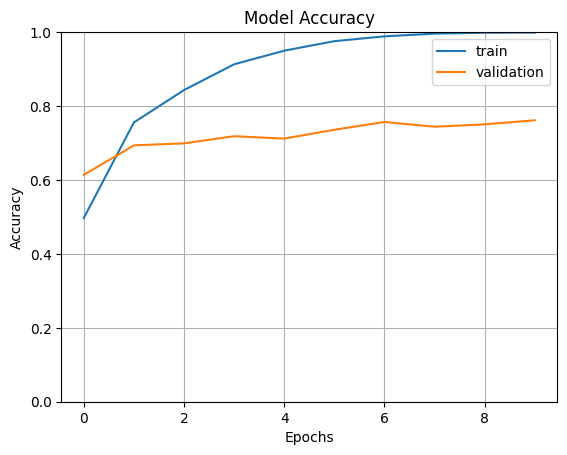

In [81]:
# plot model accuracy
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

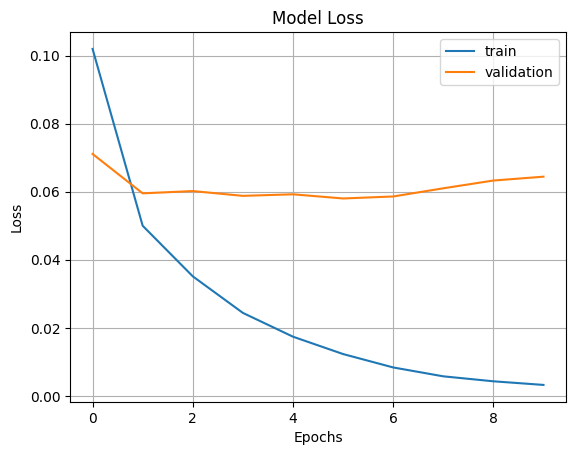

In [82]:
# plot model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [85]:
resnet_model.save('/Users/mario/Desktop/resnet_model.keras')

In [92]:
tf.keras.Model.save(self=resnet_model, filepath='/Users/mario/Desktop')

INFO:tensorflow:Assets written to: /Users/mario/Desktop/assets


INFO:tensorflow:Assets written to: /Users/mario/Desktop/assets


In [88]:
resnet_model.save('/Users/mario/Desktop/resnet_model.h5')

# Making Predictions

1/1 [==============================] - 0s 272ms/step
beans (0.636)
oats (0.311)
sugar (0.254)
cheese (0.0699)
pasta (0.0654)
carrot (0.0586)
milk (0.0364)
rice (0.0328)
potato (0.0159)
butter (0.0136)
garlic (0.00316)
spinach (0.00243)
tofu (0.0015)
onion (0.000987)
honey (0.000811)
apple (0.000309)
banana (0.000226)
tomato (0.000215)
lettuce (0.000145)
lime (0.000135)


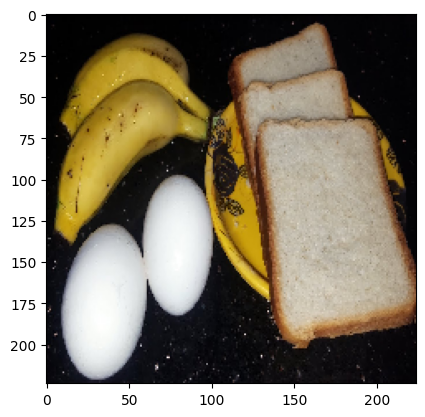

In [105]:
from keras.preprocessing import image

#Validate on an image
#img = image.load_img('movie_dataset_multilabel/images/tt4425064.jpg', target_size=(SIZE,SIZE,3))
img = image.load_img('/Users/mario/Desktop/test_val.jpg', target_size=(224,224,3))

img = image.img_to_array(img)  
img = img/255  # IS THIS WHAT IS CAUSING THE ISSUE? different from first import
plt.imshow(img)
img = np.expand_dims(img, axis=0)

classes = class_names
proba = resnet_model.predict(img)  #Get probabilities for each class
sorted_categories = np.argsort(proba[0])[:-21:-1]  #Get class names for top 10 categories

#Print classes and corresponding probabilities
for i in range(20):
    print("{}".format(classes[sorted_categories[i]])+" ({:.3})".format(proba[0][sorted_categories[i]]))


In [83]:
import cv2
image = cv2.imread(str(beef[0]))
image_resized = cv2.resize(image, (img_height,img_width))
image = np.expand_dims(image_resized,axis=0)
print(image.shape)

NameError: name 'beef' is not defined

In [34]:
probs = resnet_model.predict(image)
print(probs)

NameError: name 'image' is not defined

In [35]:
sort_cat = np.argsort(probs[0])

NameError: name 'probs' is not defined

In [36]:
for cat in range(20):
  print(f"{class_names[sort_cat[cat]]}: {probs[0][sort_cat[cat]]}")

NameError: name 'sort_cat' is not defined